# Installation Setup

In [593]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [626]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web
# from pandas_to_latex import pandas_to_latex, results_to_latex

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [627]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)
# if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
#     os.makedirs("./" + config.TRAINED_MODEL_DIR)
# if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):


In [628]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Data

In [391]:
Datasets = os.path.dirname(os.getcwd()) + "\\Data\\"
__depends__ = [Datasets+"RetailMarketOrder.sas7bdat", 
               Datasets+"InstitutionOrder.sas7bdat", 
               Datasets+"FutureReturn.sas7bdat"]
__dest__ = []

In [392]:
__depends__

['G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\RetailMarketOrder.sas7bdat',
 'G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\InstitutionOrder.sas7bdat',
 'G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\FutureReturn.sas7bdat']

## About Data

In [8]:
retail = pd.read_sas(__depends__[0], encoding = 'latin-1')
retail.columns = retail.columns.str.lower()
retail[['permno','russellgroup']] = retail[['permno','russellgroup']].astype(int)
retail.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol
14431820,93436,TSLA,TESLA INC,2021-12-27,1,XLY,"1,093.940","1,098,605.595",0.001
14431821,93436,TSLA,TESLA INC,2021-12-28,1,XLY,"1,088.470","1,093,112.295",-0.021
14431822,93436,TSLA,TESLA INC,2021-12-29,1,XLY,"1,086.190","1,090,822.542",-0.033
14431823,93436,TSLA,TESLA INC,2021-12-30,1,XLY,"1,070.340","1,074,904.966",-0.007
14431824,93436,TSLA,TESLA INC,2021-12-31,1,XLY,"1,056.780","1,092,190.615",-0.087


- permno is the permanent stock identifier used in CRSP
- Retail Market Order Imbalance (moribvol) = (Shares Purchased - Shares Sold)/(Shares Purchased+Shares Sold)
    - We standardize by dividing the sum of total buy and sell retail market orders to make this variable comparable across different stocks
    - Tracking Retail Investor Activity: https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13033
- 5 Russell groups
    - Classification of stocks according to the constituent members of Russell indices
    - Large-Cap (russellgroup = 1): stocks in Russell Top 200, which consists of the largest 200 members in Russell 1000
    - Mid-Cap (russellgroup = 2): stocks in Russell Mid-Cap, which consists of the smallest 800 members in Russell 1000
    - Small-Cap (russellgroup = 3): the largest 1000 members in Russell 2000
    - Micro-Cap (russellgroup = 4): stocks in Russell Micro-Cap, which consists of the smallest 1000 members in Russell 2000 plus the largest 1000 stocks outside Russell 2000
    - Nano-Cap (russellgroup = 5): all remaining stocks
- 11 sectors
    - The Global Industry Classification Standard (GICS)
    - I name a sector using the corresponding ticker of the SPDR sector ETF (see, https://www.sectorspdr.com/sectorspdr/)

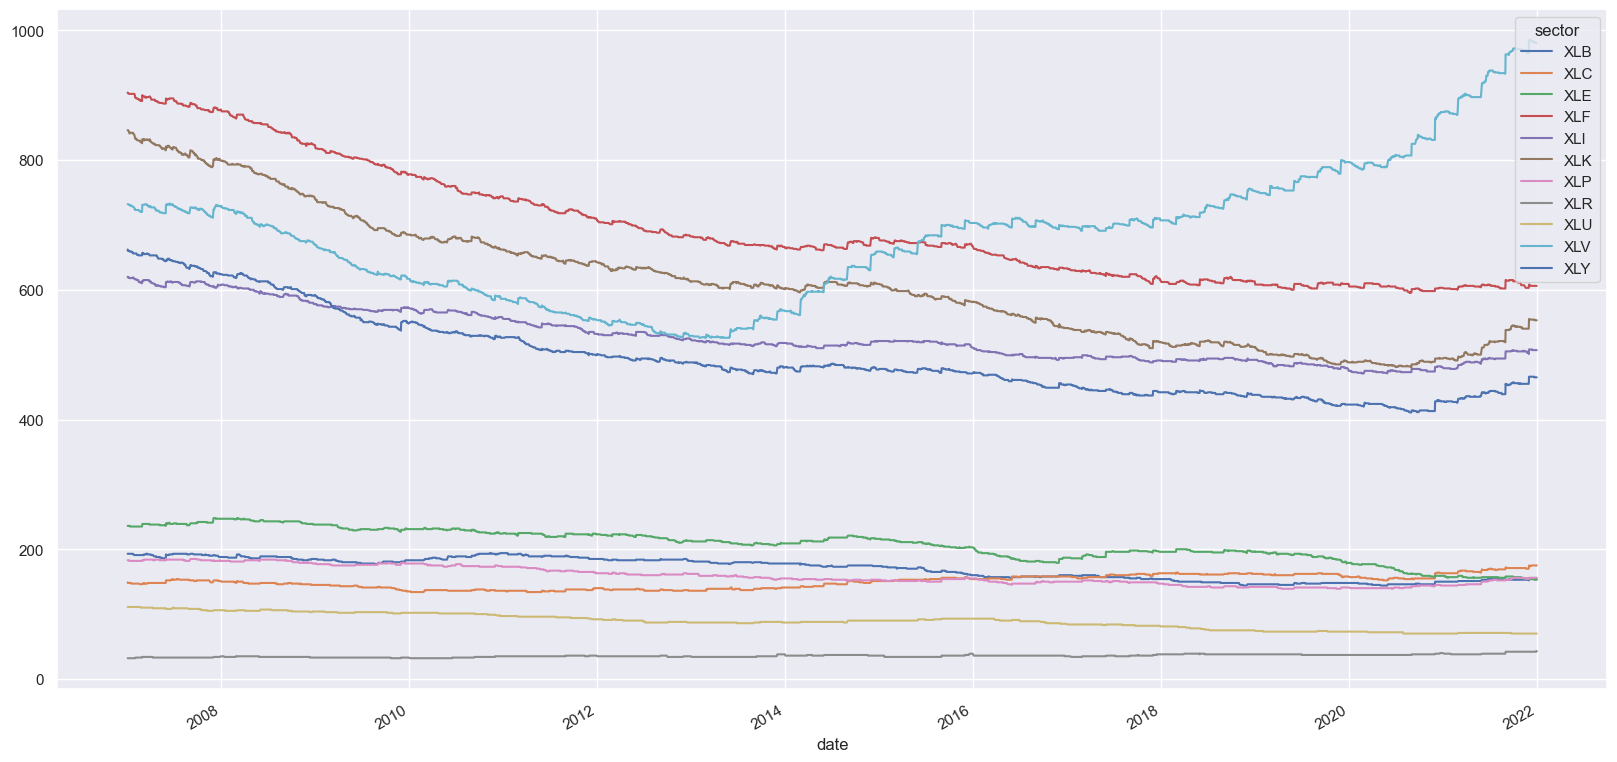

In [9]:
retail.groupby(['date','sector'])['permno'].count().unstack().plot();

In [10]:
institution = pd.read_sas(__depends__[1], encoding = 'latin-1')
institution.columns = institution.columns.str.lower()
institution[['permno','russellgroup']] = institution[['permno','russellgroup']].astype(int)
institution.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,iibvol
10772976,93436,TSLA,TESLA MOTORS INC,2011-03-25,2,XLY,22.750,"2,168.871",0.000
10772977,93436,TSLA,TESLA MOTORS INC,2011-03-28,2,XLY,23.250,"2,216.539",1.000
10772978,93436,TSLA,TESLA MOTORS INC,2011-03-29,2,XLY,23.920,"2,280.413",0.000
10772979,93436,TSLA,TESLA MOTORS INC,2011-03-30,2,XLY,23.710,"2,260.393",0.000
10772980,93436,TSLA,TESLA MOTORS INC,2011-03-31,2,XLY,27.750,"2,651.651",-1.000


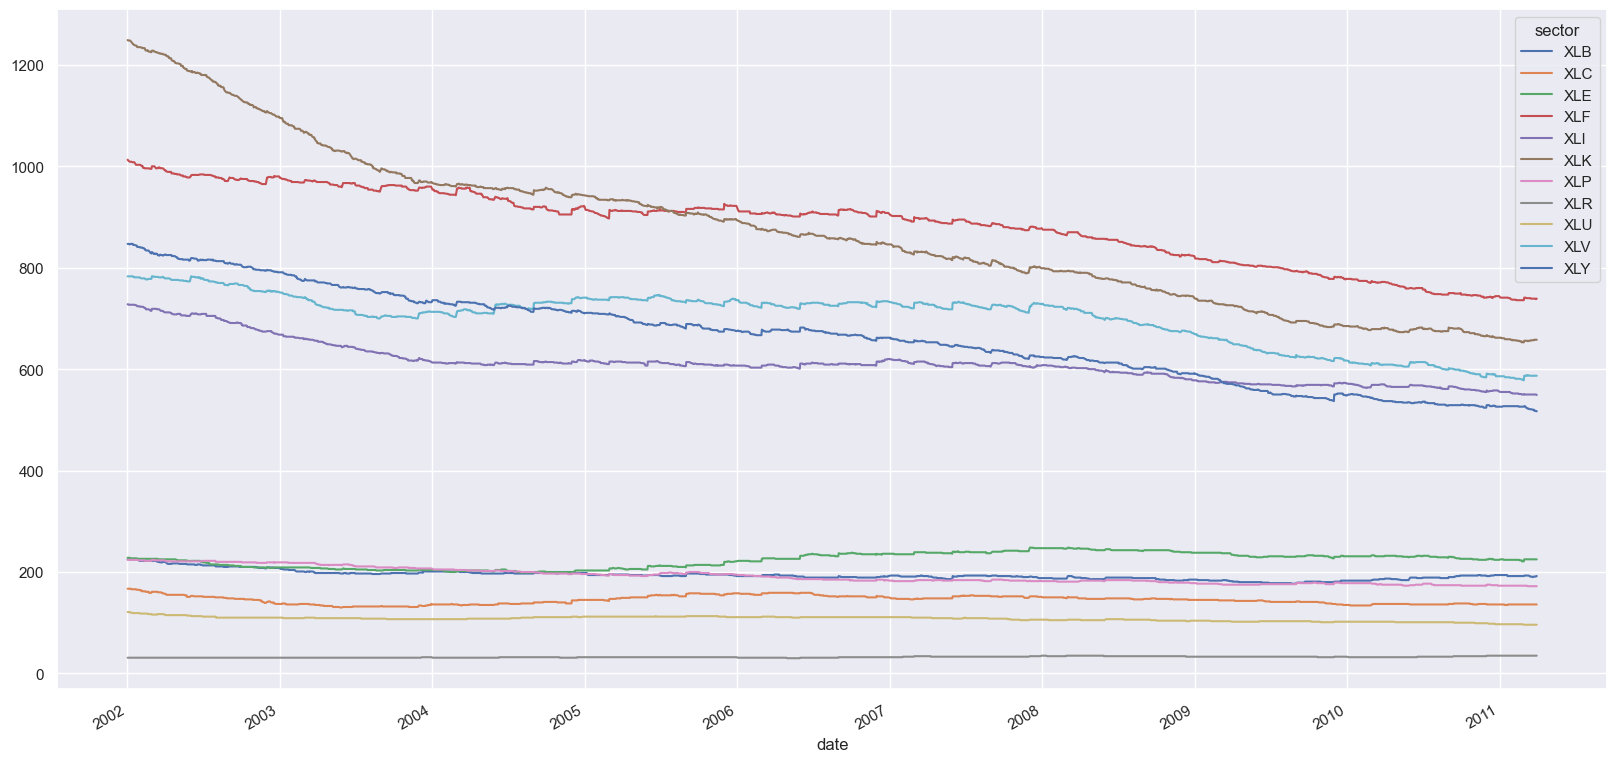

In [11]:
institution.groupby(['date','sector'])['permno'].count().unstack().plot();

In [12]:
ret = pd.read_sas(__depends__[2], encoding = 'latin-1')
ret.columns = ret.columns.str.lower()
ret['permno'] = ret['permno'].astype(int)
ret.tail()

,permno,date,ret_1,ret_5,ret_10,ret_20
21466675,93436,2021-12-27,-0.005,0.097,-0.033,-0.160
21466676,93436,2021-12-28,-0.002,0.056,-0.022,-0.139
21466677,93436,2021-12-29,-0.015,0.002,0.018,-0.237
21466678,93436,2021-12-30,-0.013,-0.005,-0.036,-0.209
21466679,93436,2021-12-31,0.135,-0.028,-0.007,-0.114


- ret_i, i = 1,5,10,20, is the return over next day, 5 days, 10 days, 20 days
    - I already moved the return backward for one trading day to avoid potentisl forward-looking bias. For example, -0.003 ret_1 of stock 93436 at 2022-06-24 is the return earned by this stock at 2022-06-27

## More Data Explorations
> In hindsight, we present stock correlation anaysis between imbalance trades and return rates in 5 days, as an example 

In [19]:
# All data points - merged retail imblance trades and returns rates
retail_ret = pd.merge(retail[['ticker','permno','date','moribvol', "russellgroup", "sector", "price"]], ret, on = ['permno','date'], how = 'inner')
retail_ret = retail_ret.rename(columns={'ticker': 'tic'})
retail_ret

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20
0,EWST,10001,2007-01-03,-1.000,5,XLU,11.100,0.023,-0.000,0.035,0.027
1,EWST,10001,2007-01-04,0.000,5,XLU,11.360,-0.010,0.008,-0.018,-0.014
2,EWST,10001,2007-01-05,0.000,5,XLU,11.250,0.008,0.010,-0.004,0.019
3,EWST,10001,2007-01-08,0.000,5,XLU,11.345,-0.009,-0.002,0.010,0.004
4,EWST,10001,2007-01-09,1.000,5,XLU,11.240,-0.012,0.019,0.019,0.014
...,...,...,...,...,...,...,...,...,...,...,...
14431820,TSLA,93436,2021-12-27,0.001,1,XLY,"1,093.940",-0.005,0.097,-0.033,-0.160
14431821,TSLA,93436,2021-12-28,-0.021,1,XLY,"1,088.470",-0.002,0.056,-0.022,-0.139
14431822,TSLA,93436,2021-12-29,-0.033,1,XLY,"1,086.190",-0.015,0.002,0.018,-0.237
14431823,TSLA,93436,2021-12-30,-0.007,1,XLY,"1,070.340",-0.013,-0.005,-0.036,-0.209


In [425]:
# Correlation anaysis between imbalance trades and return rates in 5 days
fut_ret = 'ret_5'

# tic, russellgroup, and sector may be changed with respect to a company over time...
grouped = retail_ret.groupby(['permno', 'tic', "russellgroup", "sector"])

df_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
df_correlation = df_correlation[df_correlation > 0].reset_index()
df_correlation = df_correlation.rename(columns={df_correlation.columns[-1]: 'corr'})

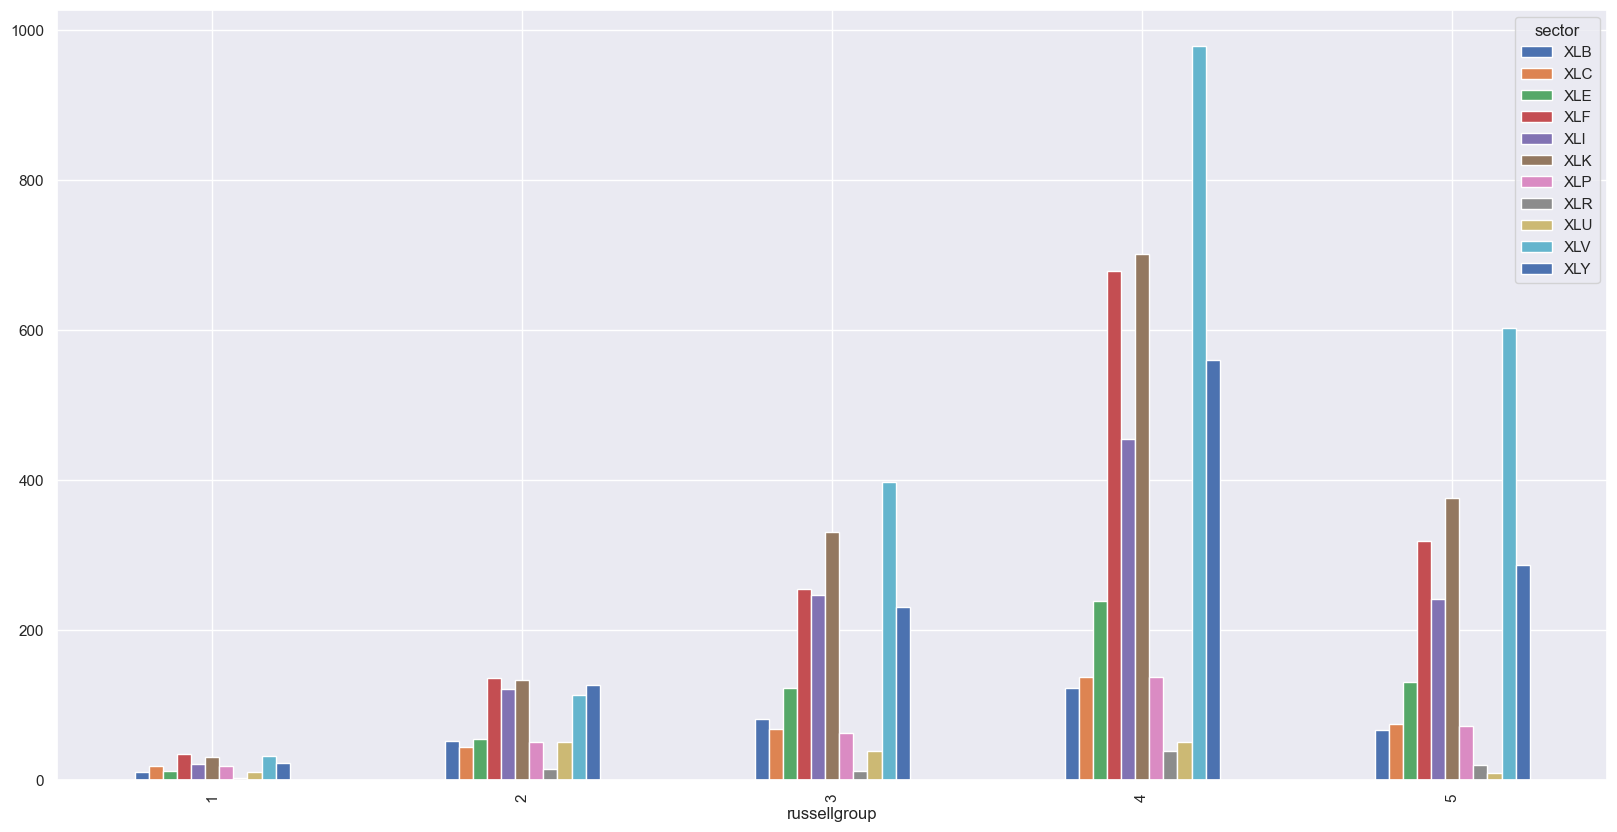

In [426]:
df_correlation.groupby(['russellgroup','sector'])['permno'].count().unstack().plot.bar();

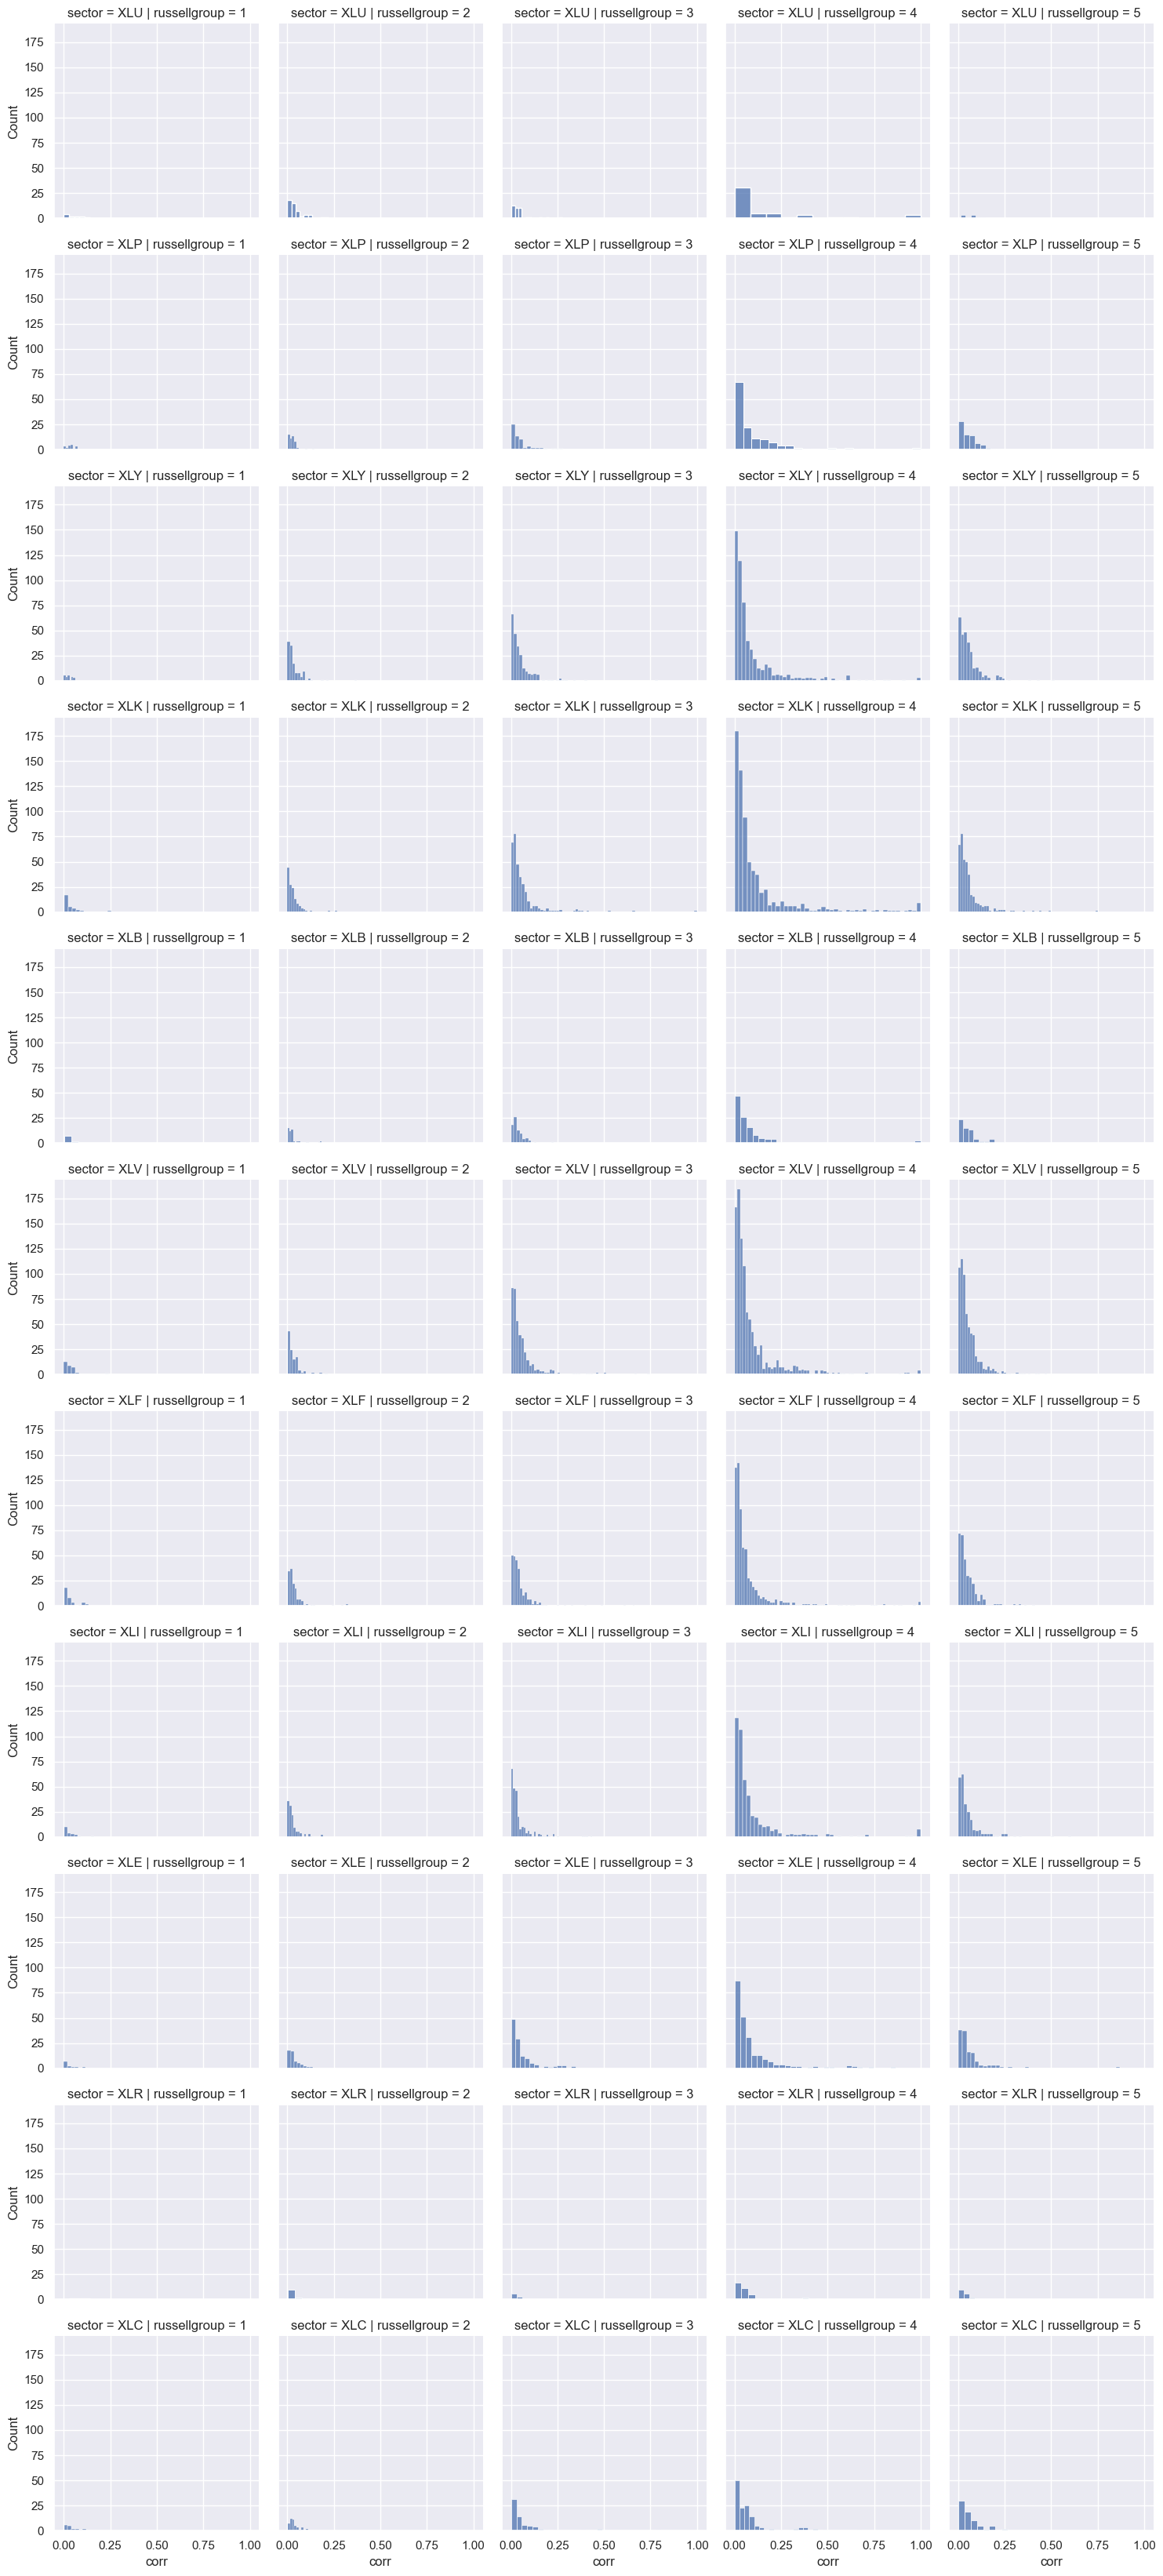

In [420]:
# A panel of plots of correlation values
g = sns.FacetGrid(df_correlation, col='russellgroup', row='sector')
g.map(sns.histplot, 'corr', kde=False)
g.fig.tight_layout()
g.fig.show()

sector
XLB    AxesSubplot(0.125,0.11;0.775x0.77)
XLC    AxesSubplot(0.125,0.11;0.775x0.77)
XLE    AxesSubplot(0.125,0.11;0.775x0.77)
XLF    AxesSubplot(0.125,0.11;0.775x0.77)
XLI    AxesSubplot(0.125,0.11;0.775x0.77)
XLK    AxesSubplot(0.125,0.11;0.775x0.77)
XLP    AxesSubplot(0.125,0.11;0.775x0.77)
XLR    AxesSubplot(0.125,0.11;0.775x0.77)
XLU    AxesSubplot(0.125,0.11;0.775x0.77)
XLV    AxesSubplot(0.125,0.11;0.775x0.77)
XLY    AxesSubplot(0.125,0.11;0.775x0.77)
Name: corr, dtype: object

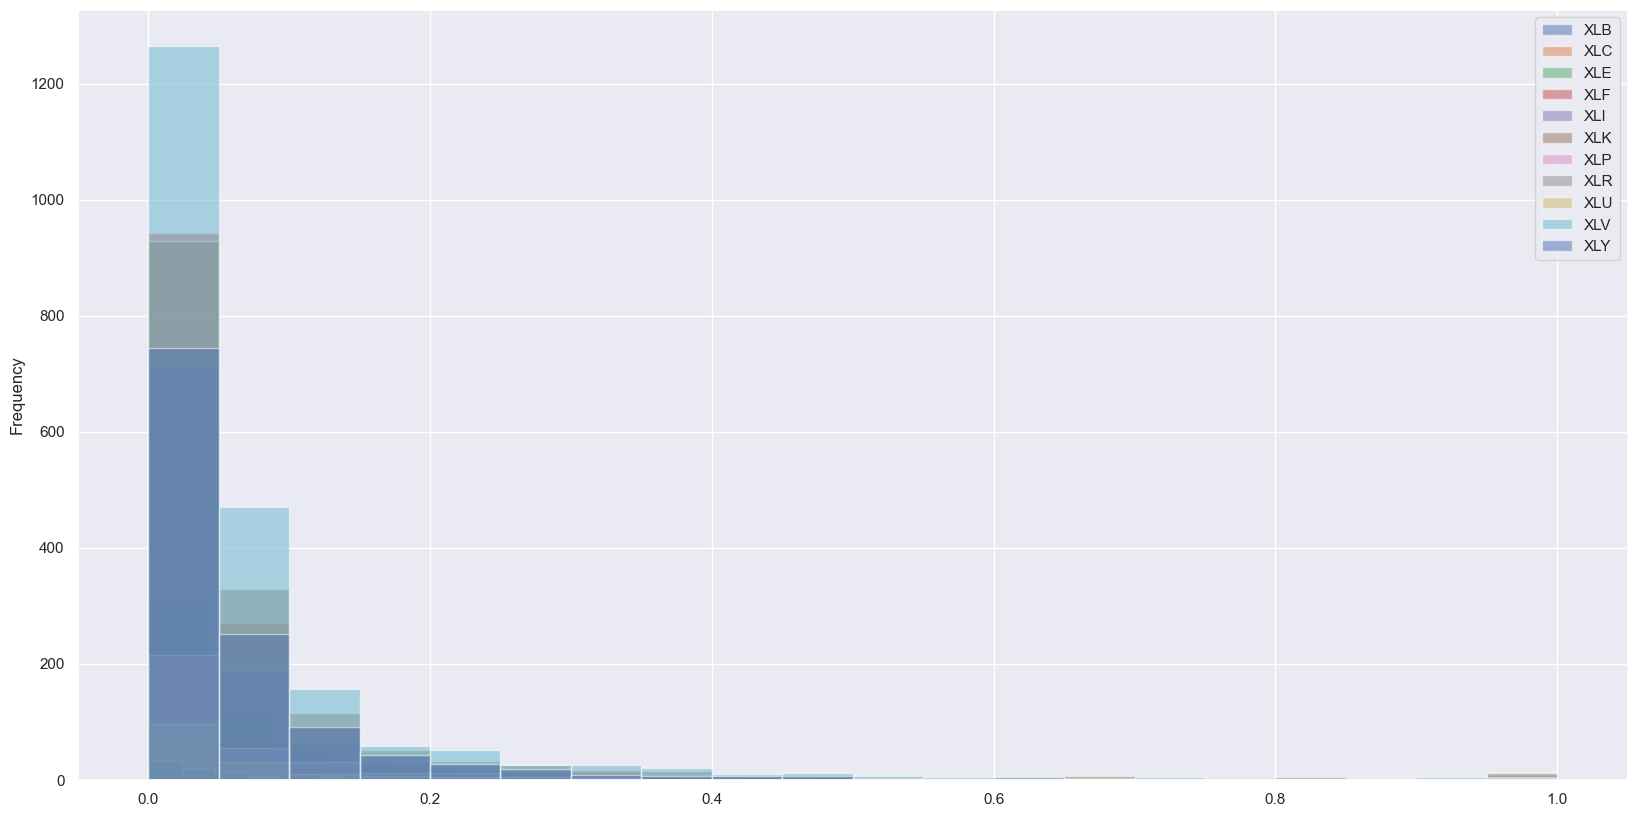

In [427]:
# Plot the distribution of correlation values for each sectors
grouped = df_correlation.groupby(['sector'])
grouped['corr'].plot.hist(alpha=0.5, bins=20)

plt.legend()
plt.show()

In [422]:
# Max correlated stocks in different cap sizes and sectors

def get_max_row(group):
    return group[group['corr'] == group['corr'].max()].iloc[0, :]

df_correlation.groupby(['russellgroup','sector']).apply(get_max_row)

permno   tic  russellgroup sector  corr
russellgroup sector                                         
1            XLB      16851  DWDP             1    XLB 0.229
             XLC      91066   VIA             1    XLC 0.121
             XLE      13141   WPX             1    XLE 0.118
             XLF      64565   CFC             1    XLF 0.134
             XLI      11955   WMI             1    XLI 0.162
             XLK      14926   CDK             1    XLK 0.256
             XLP      18163    PG             1    XLP 0.073
             XLR      91388     H             1    XLR 0.140
             XLU      24563   TXU             1    XLU 0.142
             XLV      16544  BIVV             1    XLV 0.244
             XLY      66181    HD             1    XLY 0.061
2            XLB      15917   GCP             2    XLB 0.184
             XLC      79903   HHS             2    XLC 0.114
             XLE      90180  ATLS             2    XLE 0.139
             XLF      81593    WM             2    XLF 0.326
             XLI      81285    TT             2    XLI 0.191
             XLK      81705  FEIC             2    XLK 0.267
             XLP      52038   SYY             2    XLP 0.145
             XLR      14252  GLPI             2    XLR 0.304
             XLU      14401   OGS             2    XLU 0.222
             XLV      86923   TRI             2    XLV 0.216
             XLY      18578   KTB             2    XLY 0.375
3            XLB      18075    AP             3    XLB 0.231
             XLC      92265   RCH             3    XLC 0.806
             XLE      90674   AEZ             3    XLE 0.348
             XLF      15180  ICBK             3    XLF 0.666
             XLI      91299   GFN             3    XLI 0.437
             XLK      80236  DSPG             3    XLK 1.000
             XLP      76461  VERU             3    XLP 0.282
             XLR      38746   AXR             3    XLR 0.412
             XLU      91840    RZ             3    XLU 0.276
             XLV      16670  CATS             3    XLV 0.746
             XLY      87379  CLCT             3    XLY 0.790
4            XLB      10881  ANLT             4    XLB 1.000
             XLC      65787   TRB             4    XLC 0.682
             XLE      83991   THX             4    XLE 0.867
             XLF      86300  PCBS             4    XLF 1.000
             XLI      21020   AMR             4    XLI 1.000
             XLK      15797  CSRA             4    XLK 1.000
             XLP      13598  KRFT             4    XLP 1.000
             XLR      91388     H             4    XLR 0.470
             XLU      77495  MWAV             4    XLU 1.000
             XLV      66368   CTT             4    XLV 1.000
             XLY      11873  DISK             4    XLY 1.000
5            XLB      91946   SHJ             5    XLB 0.385
             XLC      17323  LIVX             5    XLC 0.833
             XLE      79393  EWEB             5    XLE 0.871
             XLF      10682  UBMT             5    XLF 0.412
             XLI      18533   RMO             5    XLI 0.607
             XLK      15410  APPF             5    XLK 0.753
             XLP      89447  CVGW             5    XLP 0.234
             XLR      20147  HFEN             5    XLR 0.294
             XLU      84345  USEY             5    XLU 0.150
             XLV      19397   TOI             5    XLV 0.479
             XLY      18936    XL             5    XLY 0.519

## Stock Selection

> Pick 11 Large Cap Tech (XLK) firms whose retail investor trades are significantly correlatede with return rates in 5 days.

> - Stocks are ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]

In [413]:
# stock_grp = ['Large-Cap','Mid-Cap','Small-Cap','Micro-Cap','Nano-Cap']
# tech_largeCap = retail[(retail["sector"] == 'XLK')]

tech_largeCap = retail[(retail["sector"] == 'XLK')& (retail["russellgroup"] == 1)]
tech_largeCap_ret = pd.merge(tech_largeCap[['ticker','permno','date','moribvol', "price", "russellgroup"]], 
                             ret, 
                             on = ['permno','date'], 
                             how = 'inner')

tech_largeCap_ret

,ticker,permno,date,moribvol,price,russellgroup,ret_1,ret_5,ret_10,ret_20
0,SUNW,10078,2007-01-03,-0.161,5.540,1,0.027,0.083,0.045,0.182
1,SUNW,10078,2007-01-04,0.236,5.690,1,-0.016,0.079,0.014,0.165
2,SUNW,10078,2007-01-05,0.254,5.600,1,0.009,0.082,0.027,0.186
3,SUNW,10078,2007-01-08,-0.294,5.650,1,0.014,0.073,0.002,0.156
4,SUNW,10078,2007-01-09,0.762,5.730,1,0.047,0.045,0.073,0.150
...,...,...,...,...,...,...,...,...,...,...
88785,AOL,93091,2010-05-24,-0.040,21.200,1,-0.025,-0.033,-0.041,0.082
88786,AOL,93091,2010-05-25,0.038,20.680,1,0.002,0.015,-0.023,0.095
88787,AOL,93091,2010-05-26,-0.280,20.720,1,0.021,0.014,0.019,0.049
88788,AOL,93091,2010-05-27,0.159,21.160,1,-0.025,0.006,-0.008,0.038


In [17]:
tech_largeCap_ret['ticker'].unique()

array(['SUNW', 'JAVA', 'ORCL', 'MSFT', 'EMC', 'FISV', 'DELL', 'MMI',
       'IBM', 'NOW', 'WDAY', 'AAPL', 'AMAT', 'CDK', 'PYPL', 'TXN', 'HPE',
       'SQ', 'VSM', 'ZM', 'GLW', 'MOT', 'MSI', 'HPQ', 'DXC', 'ADP',
       'LRCX', 'MU', 'INTC', 'ADI', 'AMD', 'ADBE', 'SYMC', 'CSCO', 'QCOM',
       'FDC', 'INTU', 'NTAP', 'ADSK', 'BRCM', 'CTSH', 'NVDA', 'JNPR',
       'GPN', 'FIS', 'CRM', 'MA', 'WU', 'FSLR', 'VMW', 'V', 'AVGO', 'AOL'],
      dtype=object)

In [18]:
fut_ret = 'ret_5'
grouped = tech_largeCap_ret.groupby('permno')

tech_largeCap_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
tech_largeCap_correlation = tech_largeCap_correlation.sort_values(ascending=False).reset_index()
tech_largeCap_correlation = tech_largeCap_correlation.rename(columns={tech_largeCap_correlation.columns[-1]: 'corr'})

tech_largeCap_correlation = tech_largeCap_correlation.merge(tech_largeCap_ret[['ticker', 'permno', "russellgroup"]], on='permno')
tech_largeCap_correlation = tech_largeCap_correlation.drop_duplicates()
tech_largeCap_correlation

,permno,corr,ticker,russellgroup
0,14926,0.256,CDK,1
124,40125,0.105,DXC,1
165,18484,0.082,ZM,1
567,77546,0.073,FDC,1
735,77178,0.055,QCOM,1
4512,85631,0.052,ADSK,1
5145,91611,0.051,FSLR,1
5648,10078,0.045,SUNW,1
5811,10078,0.045,JAVA,1
6003,10107,0.044,MSFT,1


In [431]:
selected_tech_tic = ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]
selected_tech_ret = retail_ret[retail_ret['tic'].isin(selected_tech_tic)]

# Earliest date of public trades
min(selected_tech_ret['date'])

# latest date of public trades
max(selected_tech_ret['date'])

# Check if their lengths are consistent
assert selected_tech_ret.groupby(["permno", "tic"]).size().nunique() == 1

# Sort by date 
selected_tech_ret = selected_tech_ret.sort_values(['date','tic'])

Timestamp('2007-01-03 00:00:00')

Timestamp('2021-12-31 00:00:00')

In [26]:
from datetime import datetime as dt

tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2007,1,3))
end = tz.localize(dt.today())

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

# yf_tech = YahooDownloader(start_date = start,
#                           end_date = end,
#                           ticker_list = selected_tech_tic).fetch_data()

# # Stack
# processed = fe.preprocess_data(yf_tech)

processed = pd.DataFrame()
for symbol in selected_tech_tic:
    yf_symbol = YahooDownloader(start_date = start, end_date = end, ticker_list = [symbol]).fetch_data()
    processed_symbol = fe.preprocess_data(yf_symbol)
    processed = pd.concat([processed, processed_symbol], axis=0)

processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed['date'] = pd.to_datetime(processed['date'])

processed

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added t

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2007-01-03,37.760,38.770,36.790,25.650,24184800,QCOM,2,0.000,27.865,24.592,100.000,66.667,100.000,25.650,25.650,0.000
1,2007-01-04,37.790,39.400,37.400,26.807,26164600,QCOM,3,0.026,27.865,24.592,100.000,66.667,100.000,26.228,26.228,0.000
2,2007-01-05,38.900,38.940,37.870,26.492,18403600,QCOM,4,0.023,27.513,25.120,78.029,39.810,100.000,26.316,26.316,0.000
3,2007-01-08,38.750,38.750,38.000,26.197,13545200,QCOM,0,0.011,27.271,25.302,64.356,15.501,100.000,26.286,26.286,0.000
4,2007-01-09,38.500,38.650,37.840,25.910,15948700,QCOM,1,-0.008,27.128,25.295,54.675,-27.510,52.646,26.211,26.211,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,2023-02-15,47.500,48.520,47.330,48.450,27320000,CSCO,2,-0.001,49.369,46.347,54.005,16.601,2.525,47.979,47.951,0.756
4059,2023-02-16,49.990,51.740,49.800,50.990,48125300,CSCO,3,0.250,50.013,46.156,60.997,263.762,33.701,48.094,48.011,8.227
4060,2023-02-17,51.330,51.440,50.600,50.770,25314900,CSCO,4,0.426,50.455,46.113,60.177,240.467,33.701,48.223,48.069,0.056
4061,2023-02-21,50.710,50.760,49.620,49.690,25100500,CSCO,1,0.473,50.618,46.169,56.333,144.687,19.069,48.269,48.098,1.320


In [27]:
processed['tic'].unique()

array(['QCOM', 'ADSK', 'FSLR', 'MSFT', 'AMD', 'ORCL', 'INTU', 'WU',
       'LRCX', 'TXN', 'CSCO'], dtype=object)

In [582]:
# Merge technical indicators with returns
df_merged = pd.merge(retail_ret, processed, on=['tic', 'date'])

# Compute a set of weights for asset allocation
df_merged['moribvol'] = df_merged.groupby(['date'])['moribvol'].rank(method='dense')
df_merged['moribvol'] = df_merged.groupby('date')['moribvol'].apply(lambda x: x/x.sum())

df_merged 

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,ORCL,10104,2007-01-03,0.045,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.513,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.513,14.513,0.000
1,ORCL,10104,2007-01-04,0.091,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000
2,ORCL,10104,2007-01-05,0.015,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.449,100.000,14.596,14.596,0.000
3,ORCL,10104,2007-01-08,0.076,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.739,122.245,100.000,14.648,14.648,0.000
4,ORCL,10104,2007-01-09,0.045,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.558,107.927,100.000,14.673,14.673,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,0.015,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041
41543,FSLR,91611,2021-12-28,0.076,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038
41544,FSLR,91611,2021-12-29,0.015,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004
41545,FSLR,91611,2021-12-30,0.152,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119


In [634]:
states = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']

train_data = data_split(df_merged[states], '2007-01-01', '2018-01-01')
trade_data = data_split(df_merged[states], '2018-01-01', '2022-01-01')

# train_X = train_data[["price", "day", "tic", "date",
#                       "macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma"]]

# trade_X = trade_data[["price", "day", "tic", "date",
#                       "macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma"]]

# Used for labelling
train_y = data_split(df_merged[["moribvol", "date", "tic"]], '2007-01-01', '2018-01-01')
trade_y = data_split(df_merged[["moribvol", "date", "tic"]], '2018-01-01', '2023-01-01')

# boom bust

In [585]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2007-01-03,40.630,41.830,39.810,40.560,3873900,ADSK,2,0.000,42.034,39.856,100.000,66.667,100.000,40.560,40.560
0,2007-01-03,20.080,20.400,19.350,19.520,28350300,AMD,2,0.000,20.037,19.273,100.000,-66.667,100.000,19.520,19.520
0,2007-01-03,27.460,27.980,27.330,19.536,64226000,CSCO,2,0.000,20.520,19.066,100.000,66.667,100.000,19.536,19.536
0,2007-01-03,30.170,30.290,28.200,28.500,487000,FSLR,2,0.000,28.979,28.271,100.000,-66.667,100.000,28.500,28.500
0,2007-01-03,30.680,31.060,29.100,26.496,4734600,INTU,2,0.000,27.201,26.159,100.000,-66.667,100.000,26.496,26.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,85.630,86.050,85.500,80.353,18717400,MSFT,4,0.755,82.580,76.658,60.144,74.372,15.450,79.209,77.226
2768,2017-12-29,47.530,47.880,47.280,43.361,9750000,ORCL,4,-0.469,46.547,42.377,42.781,-104.196,16.192,44.585,44.987
2768,2017-12-29,64.360,64.650,64.000,55.656,6631800,QCOM,4,0.256,56.941,55.591,56.700,-86.780,5.702,56.881,52.835
2768,2017-12-29,104.580,105.080,104.420,90.749,2813300,TXN,4,1.784,93.422,81.992,68.523,122.502,47.232,86.948,84.777


In [586]:
trade_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2018-01-02,105.340,107.160,104.390,107.120,2040600,ADSK,1,-3.126,109.299,103.069,42.401,-46.823,16.989,111.624,116.601
0,2018-01-02,10.420,11.020,10.340,10.980,44146300,AMD,1,-0.118,11.174,9.591,47.857,16.873,1.262,10.656,11.574
0,2018-01-02,38.670,38.950,38.430,33.136,20135700,CSCO,1,0.546,33.333,31.723,68.414,104.513,41.566,32.173,30.622
0,2018-01-02,67.840,70.500,67.840,70.430,1752200,FSLR,1,2.129,74.356,61.051,63.063,70.593,22.722,65.429,59.588
0,2018-01-02,158.220,158.850,157.010,152.836,1436100,INTU,1,1.228,155.434,147.894,59.470,59.491,11.443,150.864,147.513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,338.510,339.360,335.850,332.365,18000800,MSFT,4,2.333,343.209,315.177,55.069,41.029,10.666,330.022,322.471
1007,2021-12-31,88.050,88.100,87.180,85.402,5908200,ORCL,4,-1.536,102.358,79.414,43.416,-97.508,15.966,90.801,92.164
1007,2021-12-31,183.310,185.150,182.600,179.004,4113300,QCOM,4,3.563,185.222,170.820,59.872,46.185,34.435,177.464,158.469
1007,2021-12-31,189.410,190.000,188.270,181.990,2813900,TXN,4,-0.804,192.027,176.924,47.910,-71.323,5.853,185.032,185.000


# Modelling
> Use a two-stage scheme (supervised learning & reinforcement learning), in analogy to AlphaGo and ChatGPT. The first stage learns from human trader logs, while the second stage leverages reinforcement learning to achieve super-human performance.

## Environment configuration
> A gym-style portfolio allocation environment for agents to interact. They are two generated environment for train and trade periods. 

In [661]:
train = train_data
trade = trade_data

stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train, **env_kwargs)
# env_train, _ = e_train_gym.get_sb_env()
# print(type(env_train))

e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade, **env_kwargs)
# env_trade, _ = e_train_gym.get_sb_env()
# print(type(env_trade))

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


## Sampling

In [727]:
def sample_from_env(i, env, is_train, weight_type="RETAIL"):    
    random.seed(i)
    
    obs = env.reset()
    done = False
    info = {}
    data = []
    
    obs_ = []
    next_obs_ = []
    action_ = []
    reward_ = []
    done_ = []
    
    day = 0
    while not done:
        if weight_type == "EQUAL": 
            action = [1/stock_dimension] * stock_dimension    
        elif weight_type == "RETAIL": 
            # retail 
            action = list(train_y.loc[day]["moribvol"]) if is_train else list(trade_y.loc[day]["moribvol"])
            day += 1
        elif weight_type == "RANDOM": 
            action = env.action_space.sample()
        elif weight_type == "MEAN VAR": 
            # retail 
            action = list(mean_var_df.iloc[day, 1:])
            day += 1
            
        ## Greedy
        # action = [0] * 1 + [1] 
    
        next_obs, reward, done, info = env.step(action)
        if done: break
        
        obs_.append(obs)
        next_obs_.append(next_obs)
        action_.append(action)
        reward_.append(reward)
        done_.append(done)
        obs = next_obs

    return {
        'observations': np.array(obs_),
        'actions': np.array(action_),
        'next_observations': np.array(next_obs_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
    }


In [986]:
train_dataset = sample_from_env(i=0, env=e_train_gym, is_train=True)

begin_total_asset:1000000
end_total_asset:4904429.813589606
Sharpe:  0.672977603073639


## Benchmarks
 - Mean Variance
 - Equally weighted
 - Market indexes (NASDAQ and XLK)
 - Individual stocks

In [823]:
# Mean variance
mean_var_df = pd.read_csv('../data/mean_var_weight.csv')
mean_var_df = pd.concat([mean_var_df.iloc[[0]], mean_var_df], ignore_index=True)
mean_var_df = pd.concat([mean_var_df, mean_var_df.iloc[[len(mean_var_df)-1]]], ignore_index=True)
mean_var_df.loc[0, 'date'] = '2007-01-03'
mean_var_df.loc[len(mean_var_df)-1, 'date'] = '2017-12-29'

mean_var_dataset = sample_from_env(i=0, env=e_train_gym, is_train=True, weight_type="MEAN VAR")
mean_var_cum_ret = pd.DataFrame({'ret': 1000000 + np.insert(mean_var_dataset['rewards'].cumsum(), 0, 0, axis=0)})
mean_var_cum_ret['ret'] /= 1000000

begin_total_asset:1000000
end_total_asset:2954459.3281811364
Sharpe:  0.5883896321576059


In [767]:
# XLK
yf_xlk = YahooDownloader(start_date = start,
                         end_date = end,
                         ticker_list = ["XLK"]).fetch_data()

yf_xlk = fe.preprocess_data(yf_xlk)
yf_xlk = yf_xlk.copy()
yf_xlk = yf_xlk.fillna(0)
yf_xlk = yf_xlk.replace(np.inf,0)
yf_xlk['date'] = pd.to_datetime(yf_xlk['date'])
yf_xlk = data_split(yf_xlk, '2007-01-01', '2018-01-01')  
yf_xlk['ret'] = yf_xlk['open'] / yf_xlk['open'].iloc[0]

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4063, 8)
Successfully added technical indicators
Successfully added turbulence index


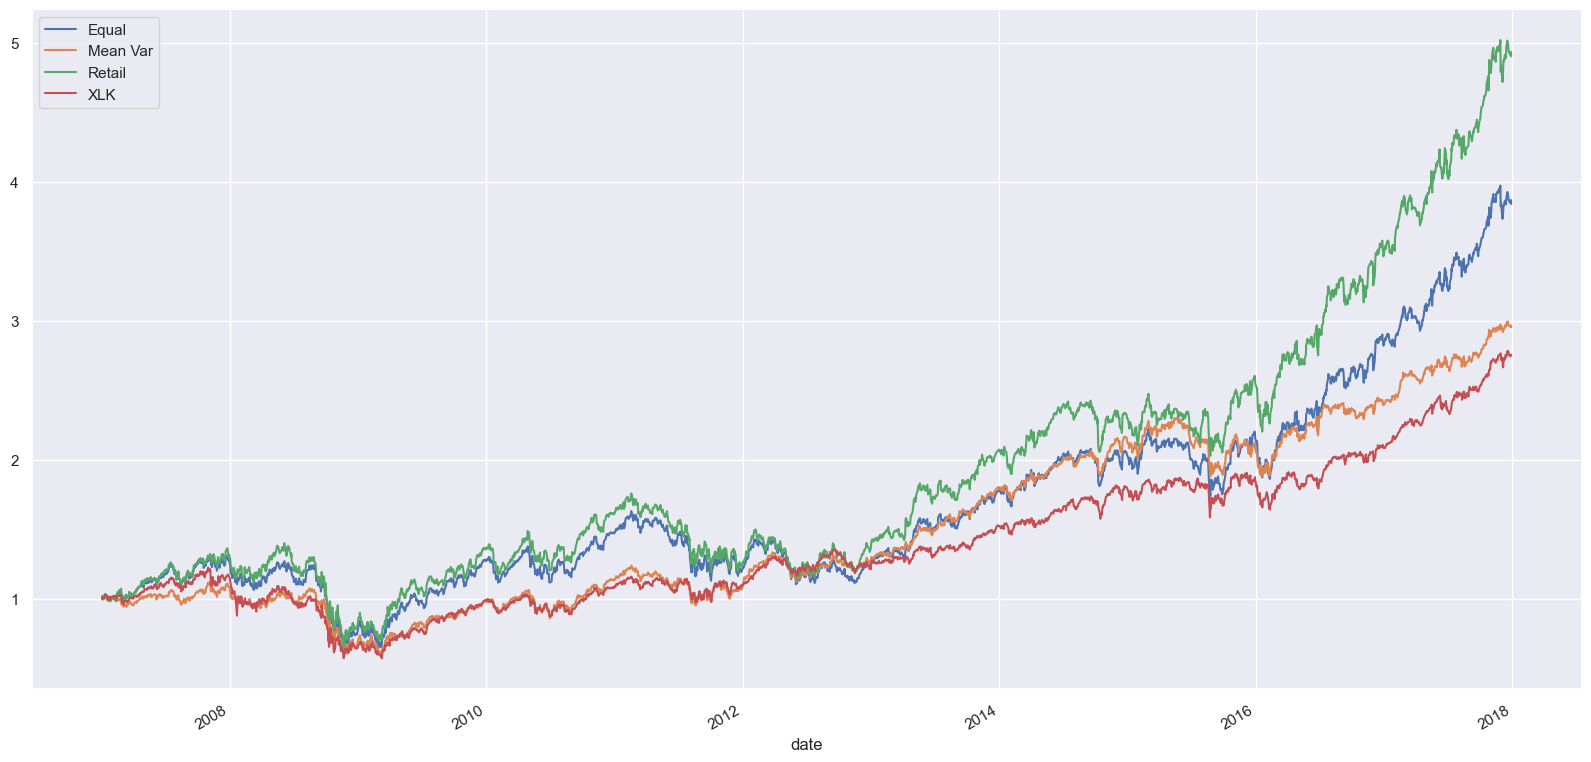

In [957]:
grouped = df_merged.groupby('tic')
selected_cum_ret = grouped.apply(lambda x: x['open']/x['open'].iloc[0])
selected_cum_ret = selected_cum_ret.reset_index()
selected_cum_ret = selected_cum_ret.set_index('level_1')
selected_cum_ret = selected_cum_ret.join(df_merged[['date']])
selected_cum_ret = data_split(selected_cum_ret, '2007-01-01', '2018-01-01')

fig, ax = plt.subplots()

# Equal
equal_cum_ret = pd.read_csv(r"C:\Users\kentw\Downloads\equal_cumulative_reward.csv", names=['ret'])
# equal_cum_ret = pd.read_csv("./results/equal_cumulative_reward.csv", names=['ret'])
equal_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = equal_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Equal")

# Mean Variance
mean_var_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = mean_var_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Mean Var")

# Retail
retail_cum_ret = pd.read_csv(r"C:\Users\kentw\Downloads\retail_cumulative_reward.csv", names=['ret'])
# retail_cum_ret = pd.read_csv("results/retail_cumulative_reward.csv", names=['ret'])
retail_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = retail_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Retail")

# XLK
ax = yf_xlk.plot(ax=ax, kind='line', x='date', y='ret', label="XLK")

plt.show()

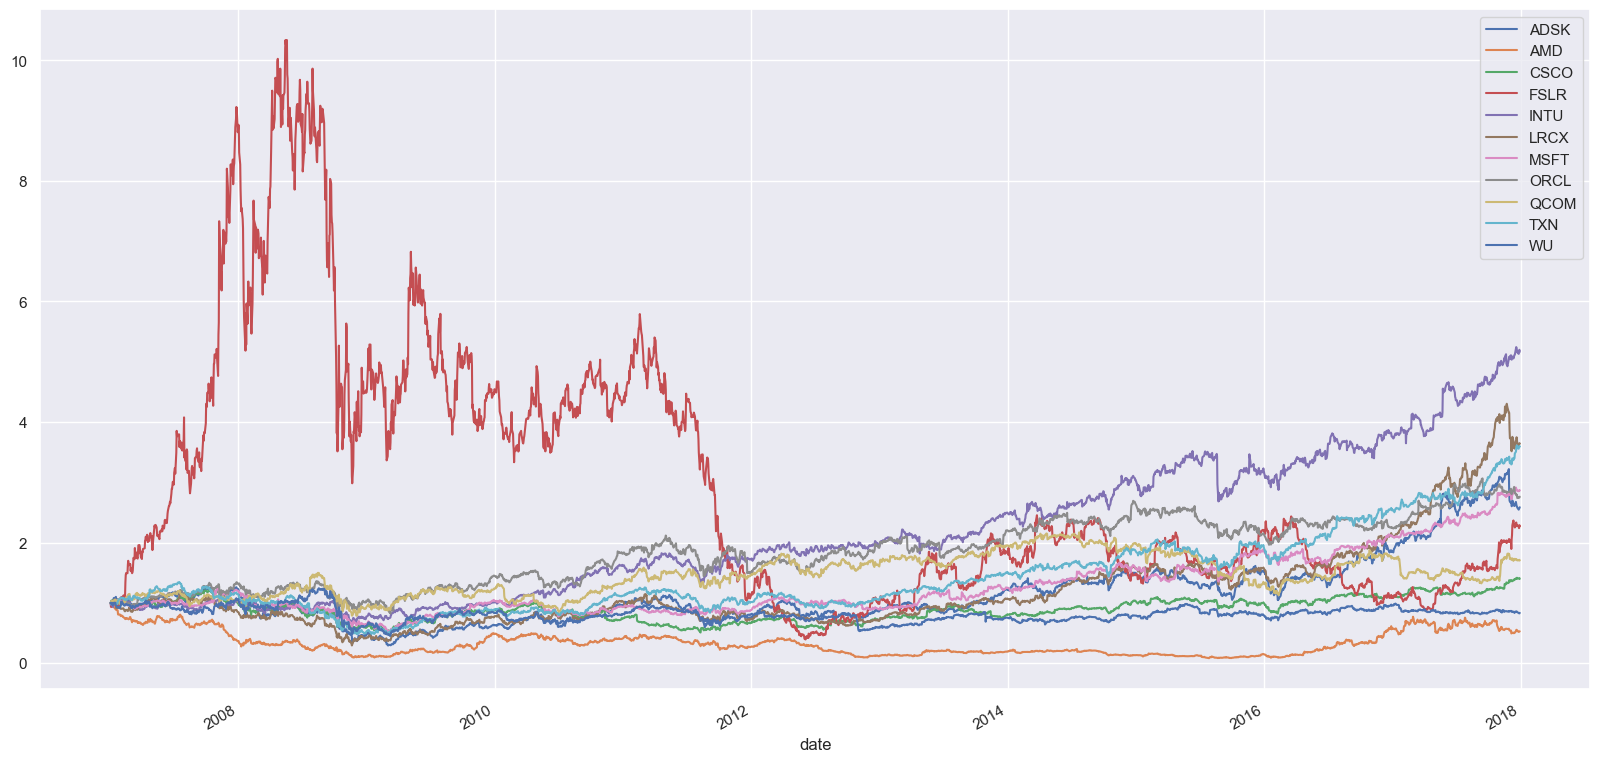

In [435]:
fig, ax = plt.subplots()

# 个股
for key, grp in selected_cum_ret.groupby(['tic']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='open', label=key)
    
plt.show()

## First stage - Supervised Learning

In [617]:
import numpy as np
import torch
import gym
import argparse
import os
# import d4rl

import utils
import TD3_BC

In [876]:
# Runs policy for X episodes and returns D4RL score
# A fixed seed is used for the eval environment

def eval_policy(policy, eval_env, seed, mean, std, seed_offset=100, eval_episodes=1):
    # eval_env = gym.make(env_name)
    eval_env.reset()
    eval_env.seed(seed + seed_offset)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            state = (np.array(state).reshape(1,-1) - mean)/std
            action = policy.select_action(state)
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    # 	d4rl_score = eval_env.get_normalized_score(avg_reward) * 100

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    # 	print(f"Evaluation over {eval_episodes} episodes")
    print("---------------------------------------")
    return avg_reward

In [654]:
# Experiment
policy = "TD3+BC" # Policy name
env = e_train_gym # OpenAI gym environment name
seed = 0 # Sets Gym, PyTorch and Numpy seeds
eval_freq = 1e3 # How often (time steps) we evaluate
max_timesteps = 1e5 # Max time steps to run environment
save_model = True # Save model and optimizer parameters
load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
file_name = f"BC_{seed}"

# TD3
expl_noise = 0.1 # Std of Gaussian exploration noise
batch_size = 256 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 0.2 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 1 # Frequency of delayed policy updates

# TD3 + BC
alpha = 0
normalize = True

In [655]:
print("---------------------------------------")
print(f"Policy: {policy}, Env: {env}, Seed: {seed}")
print("---------------------------------------")

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": discount,
    "tau": tau,
    # TD3
    "policy_noise": policy_noise * max_action,
    "noise_clip": noise_clip * max_action,
    "policy_freq": policy_freq,
    # TD3 + BC
    "alpha": alpha
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)

# if load_model != "":
#     policy_file = file_name if load_model == "default" else load_model
#     policy.load(f"./models/{policy_file}")

replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(train_dataset)

# flatten
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

if normalize:
    mean,std = replay_buffer.normalize_states() 
else:
    mean,std = 0,1

---------------------------------------
Policy: TD3+BC, Env: <StockPortfolioEnv instance>, Seed: 0
---------------------------------------


[0]

In [621]:
days = len(env.actions_memory)
evaluations = []
portfolio_values = []
fitted = []

for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        print(f"Time steps: {t+1}")
        evaluations.append(eval_policy(policy, env, seed, mean, std))
        portfolio_values.append(env.portfolio_value)
        fitted.append(np.mean((np.array(env.actions_memory) - np.array(train_y.loc[:days-1]["moribvol"]).reshape(-1, 11)) ** 2))
        
        # np.save(f"./results/{file_name}", evaluations)
        # if save_model: policy.save(f"./models/{file_name}")

Time steps: 1000
begin_total_asset:1000000
end_total_asset:3700521.4896843885
Sharpe:  0.5845894594838171
---------------------------------------
Evaluation over 1 episodes: 2700521.490
---------------------------------------
Time steps: 2000
begin_total_asset:1000000
end_total_asset:3747723.240335755
Sharpe:  0.5850651476131034
---------------------------------------
Evaluation over 1 episodes: 2747723.240
---------------------------------------
Time steps: 3000
begin_total_asset:1000000
end_total_asset:3933291.816000697
Sharpe:  0.6009488841650048
---------------------------------------
Evaluation over 1 episodes: 2933291.816
---------------------------------------
Time steps: 4000
begin_total_asset:1000000
end_total_asset:4051438.5320753437
Sharpe:  0.6116155177615634
---------------------------------------
Evaluation over 1 episodes: 3051438.532
---------------------------------------
Time steps: 5000
begin_total_asset:1000000
end_total_asset:4074571.25920142
Sharpe:  0.61131374436

Time steps: 29000
begin_total_asset:1000000
end_total_asset:4889653.500664485
Sharpe:  0.673183253153277
---------------------------------------
Evaluation over 1 episodes: 3889653.501
---------------------------------------
Time steps: 30000
begin_total_asset:1000000
end_total_asset:4660815.206619669
Sharpe:  0.6554724105549106
---------------------------------------
Evaluation over 1 episodes: 3660815.207
---------------------------------------
Time steps: 31000
begin_total_asset:1000000
end_total_asset:4828775.748255477
Sharpe:  0.6671907488613122
---------------------------------------
Evaluation over 1 episodes: 3828775.748
---------------------------------------
Time steps: 32000
begin_total_asset:1000000
end_total_asset:4800938.736400905
Sharpe:  0.6655700897285654
---------------------------------------
Evaluation over 1 episodes: 3800938.736
---------------------------------------
Time steps: 33000
begin_total_asset:1000000
end_total_asset:4808475.917346554
Sharpe:  0.66687058

Time steps: 57000
begin_total_asset:1000000
end_total_asset:4822805.679904107
Sharpe:  0.66776284747046
---------------------------------------
Evaluation over 1 episodes: 3822805.680
---------------------------------------
Time steps: 58000
begin_total_asset:1000000
end_total_asset:4821576.880874098
Sharpe:  0.6672224421052377
---------------------------------------
Evaluation over 1 episodes: 3821576.881
---------------------------------------
Time steps: 59000
begin_total_asset:1000000
end_total_asset:4889829.9155712705
Sharpe:  0.6724099155894426
---------------------------------------
Evaluation over 1 episodes: 3889829.916
---------------------------------------
Time steps: 60000
begin_total_asset:1000000
end_total_asset:4862024.577388844
Sharpe:  0.6701775034131917
---------------------------------------
Evaluation over 1 episodes: 3862024.577
---------------------------------------
Time steps: 61000
begin_total_asset:1000000
end_total_asset:4815108.1256843135
Sharpe:  0.6677932

Time steps: 85000
begin_total_asset:1000000
end_total_asset:4878854.380531213
Sharpe:  0.6699827855333034
---------------------------------------
Evaluation over 1 episodes: 3878854.381
---------------------------------------
Time steps: 86000
begin_total_asset:1000000
end_total_asset:4853352.2482819455
Sharpe:  0.6696940661012586
---------------------------------------
Evaluation over 1 episodes: 3853352.248
---------------------------------------
Time steps: 87000
begin_total_asset:1000000
end_total_asset:4943894.979654478
Sharpe:  0.6757480968620482
---------------------------------------
Evaluation over 1 episodes: 3943894.980
---------------------------------------
Time steps: 88000
begin_total_asset:1000000
end_total_asset:4784871.616434107
Sharpe:  0.663763095724663
---------------------------------------
Evaluation over 1 episodes: 3784871.616
---------------------------------------
Time steps: 89000
begin_total_asset:1000000
end_total_asset:4910223.61003359
Sharpe:  0.67322082

## Mertrics

In [622]:
if file_name == f"BC_{seed}":
    evaluations_0 = evaluations.copy()
    portfolio_values_0 = portfolio_values.copy()
    fitted_0 = fitted.copy()
elif file_name == f"TD3+BC_{seed}":
    evaluations_1 = evaluations.copy()
    portfolio_values_1 = portfolio_values.copy()
    fitted_1 = fitted.copy()

evaluations_2 = sum(train_dataset["rewards"])
portfolio_values_2 = sum(train_dataset["rewards"]) + 1000000 # 1000000 being initial capital

### Cumulative rewards

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'cumulative rewards (PnL)')

Text(0.5, 0, 'timesteps')

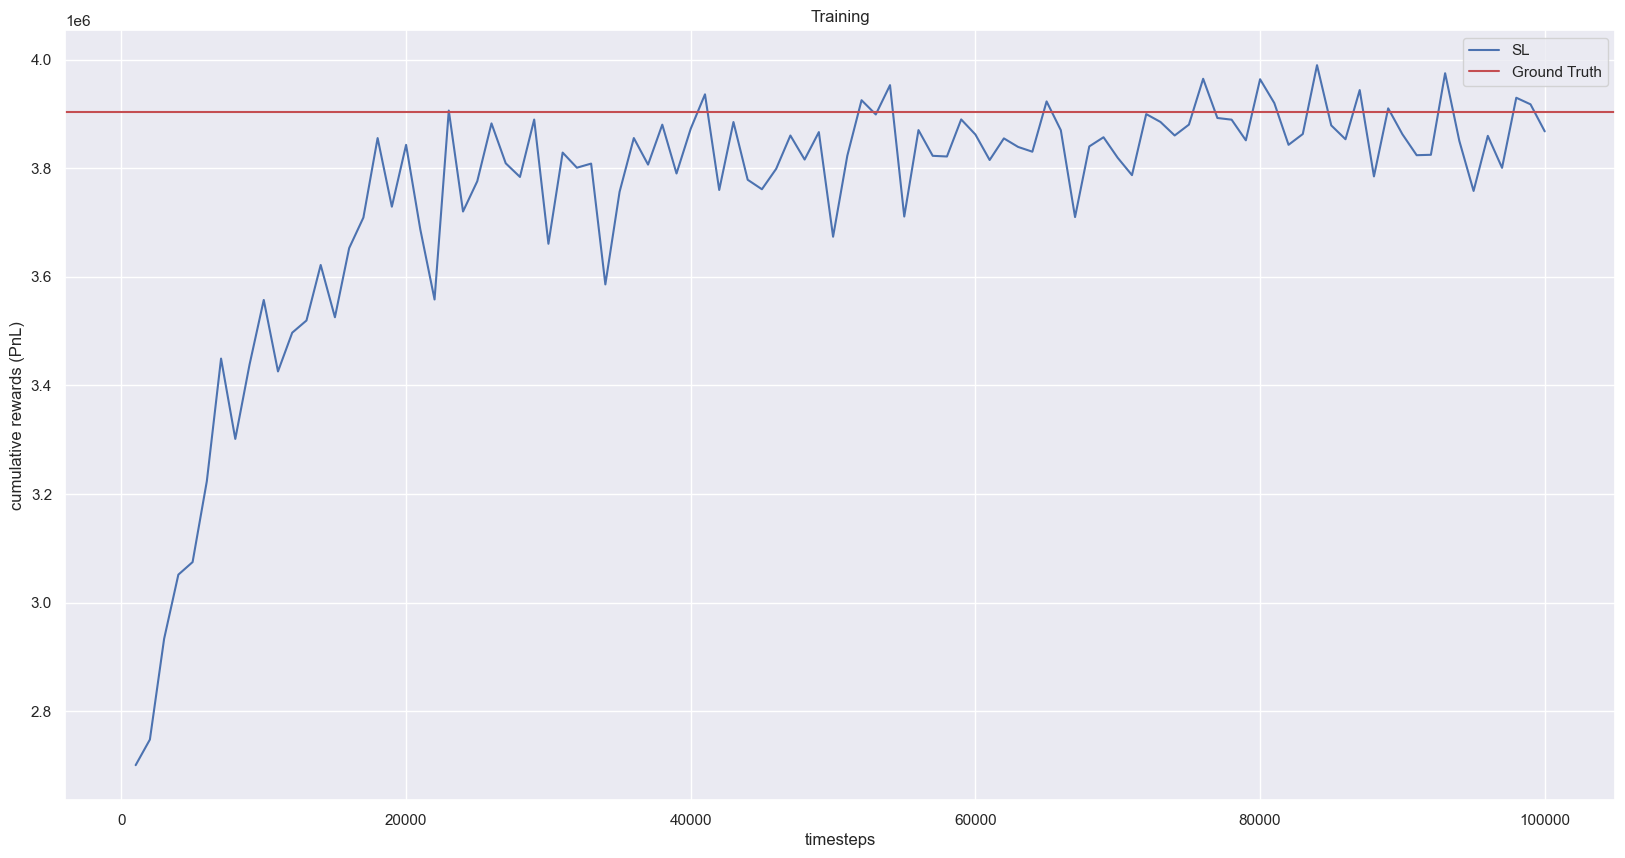

In [629]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')
plt.axhline(y=evaluations_2, label='Ground Truth', color = 'r')

plt.legend()
plt.title('Training')
plt.ylabel('cumulative rewards (PnL)')
plt.xlabel('timesteps')
plt.show()

### Portfolio values

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'timesteps')

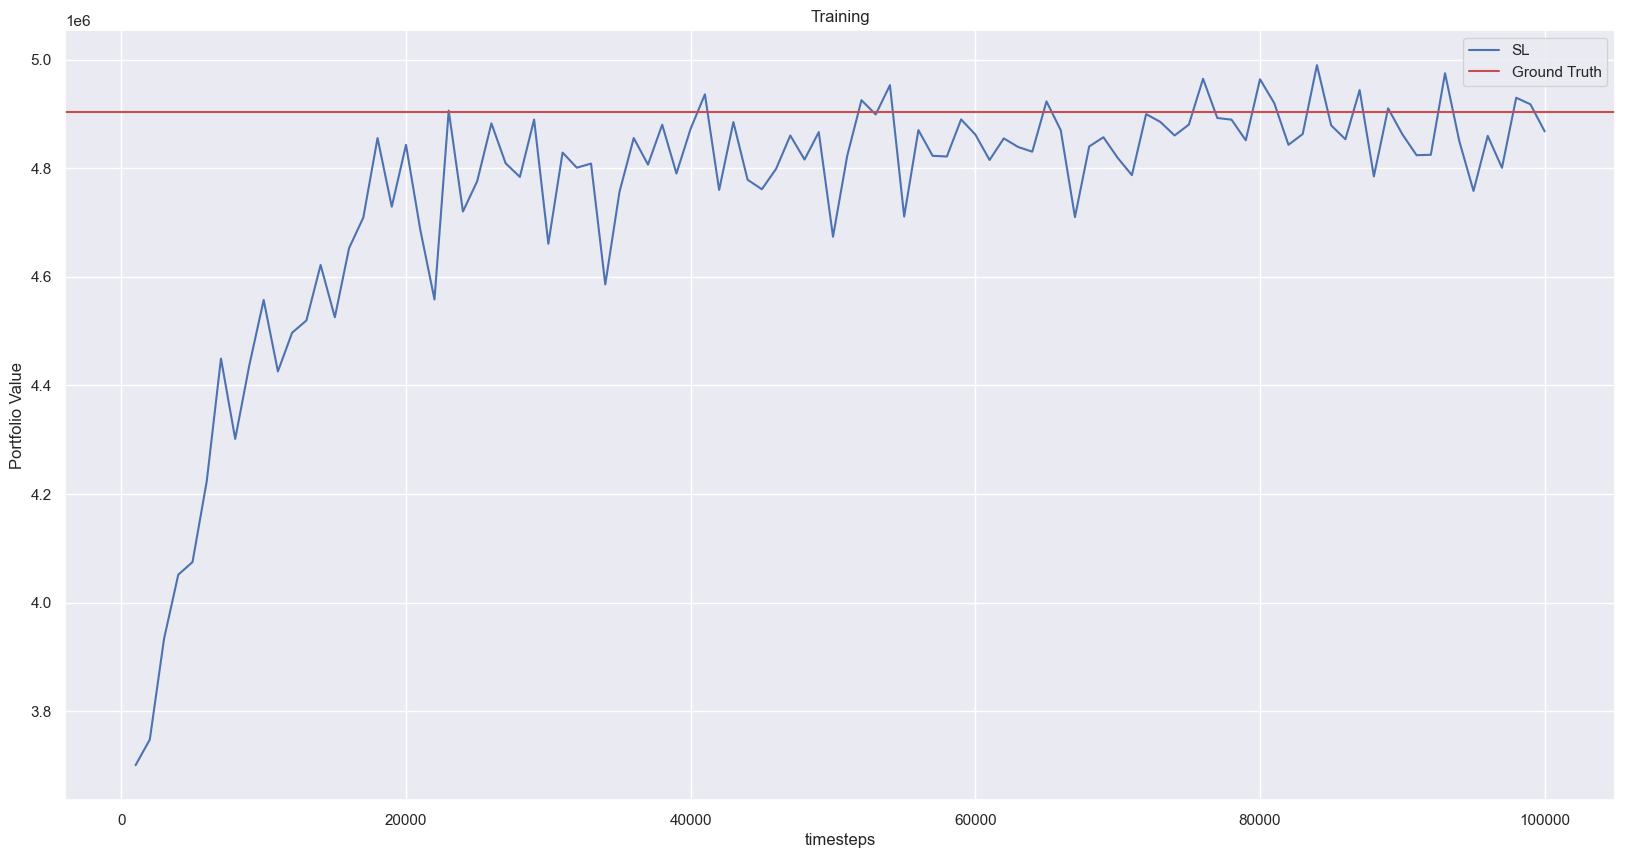

In [630]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), portfolio_values_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')
plt.axhline(y=portfolio_values_2, label='Ground Truth', color = 'r')

plt.legend()
plt.title('Training')
plt.ylabel('Portfolio Value')
plt.xlabel('timesteps')
plt.show()

### MSE

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'timesteps')

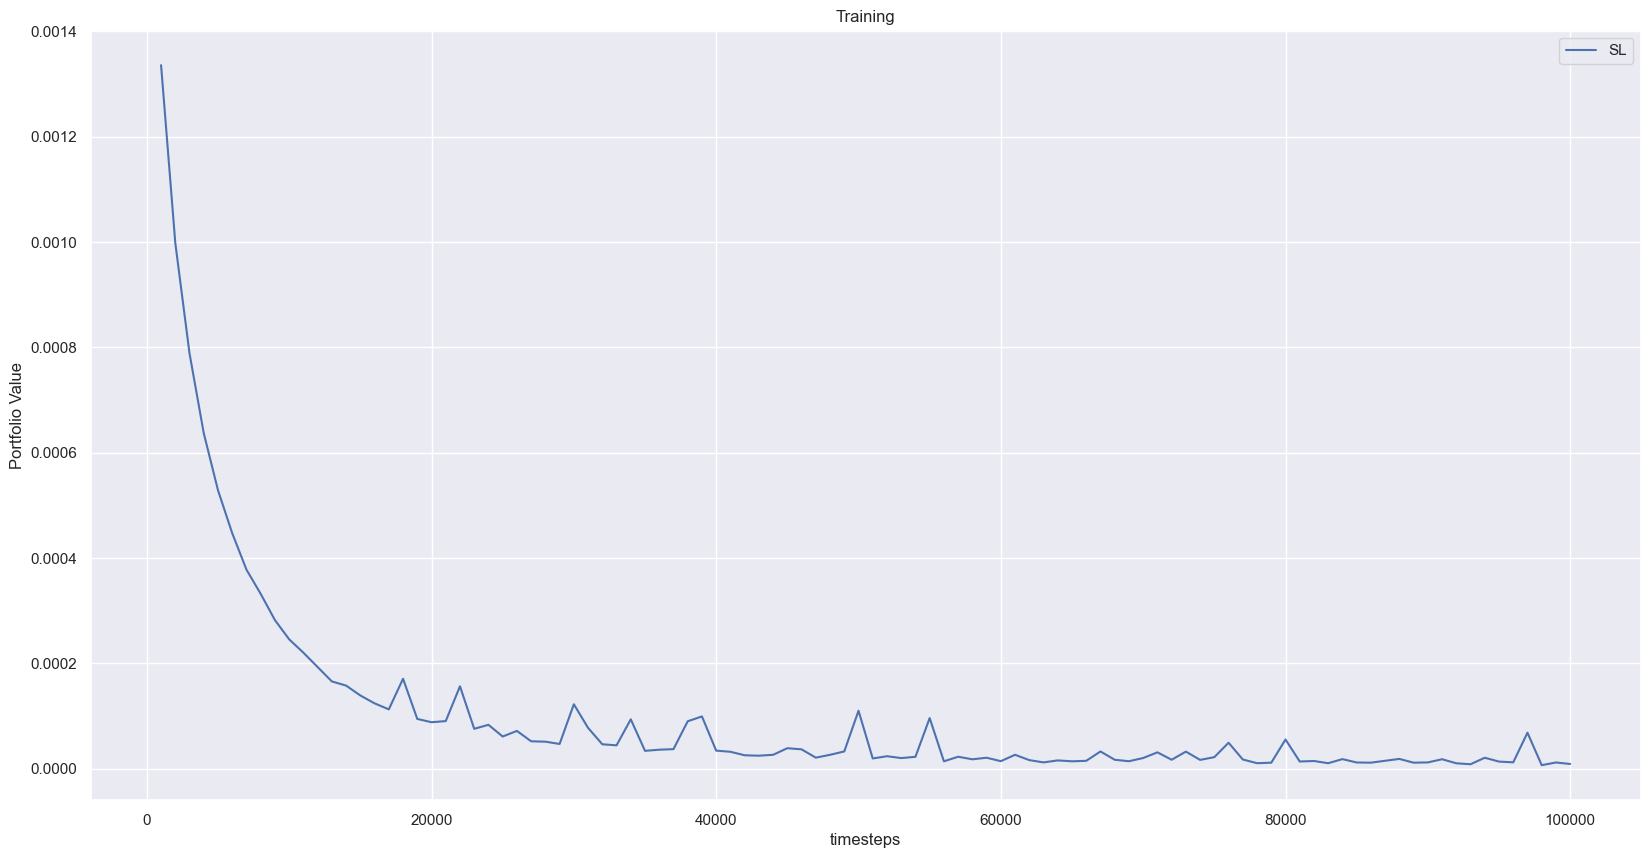

In [631]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), fitted_0, label='SL')
# plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations_1, label='SL+RL')

plt.legend()
plt.title('Training')
plt.ylabel('MSE')
plt.xlabel('timesteps')
plt.show()

### Backtest

In [963]:
from copy import deepcopy
trade_dataset = sample_from_env(i=0, env=e_trade_gym, is_train=False)
true_asset_memory_trade = deepcopy(e_trade_gym.asset_memory)
true_action_memory_trade = deepcopy(e_trade_gym.actions_memory)

begin_total_asset:1000000
end_total_asset:3226196.167978017
Sharpe:  1.1748183619545847


In [964]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(trade_dataset)
seed = 0

# flatten
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

if normalize:
    mean,std = replay_buffer.normalize_states() 
else:
    mean,std = 0,1
    
eval_policy(policy, e_trade_gym, seed, mean, std)

begin_total_asset:1000000
end_total_asset:3193611.302462622
Sharpe:  1.1972357498477915
---------------------------------------
Evaluation over 1 episodes: 2193611.302
---------------------------------------


2193611.302462622

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Portfolio values ')

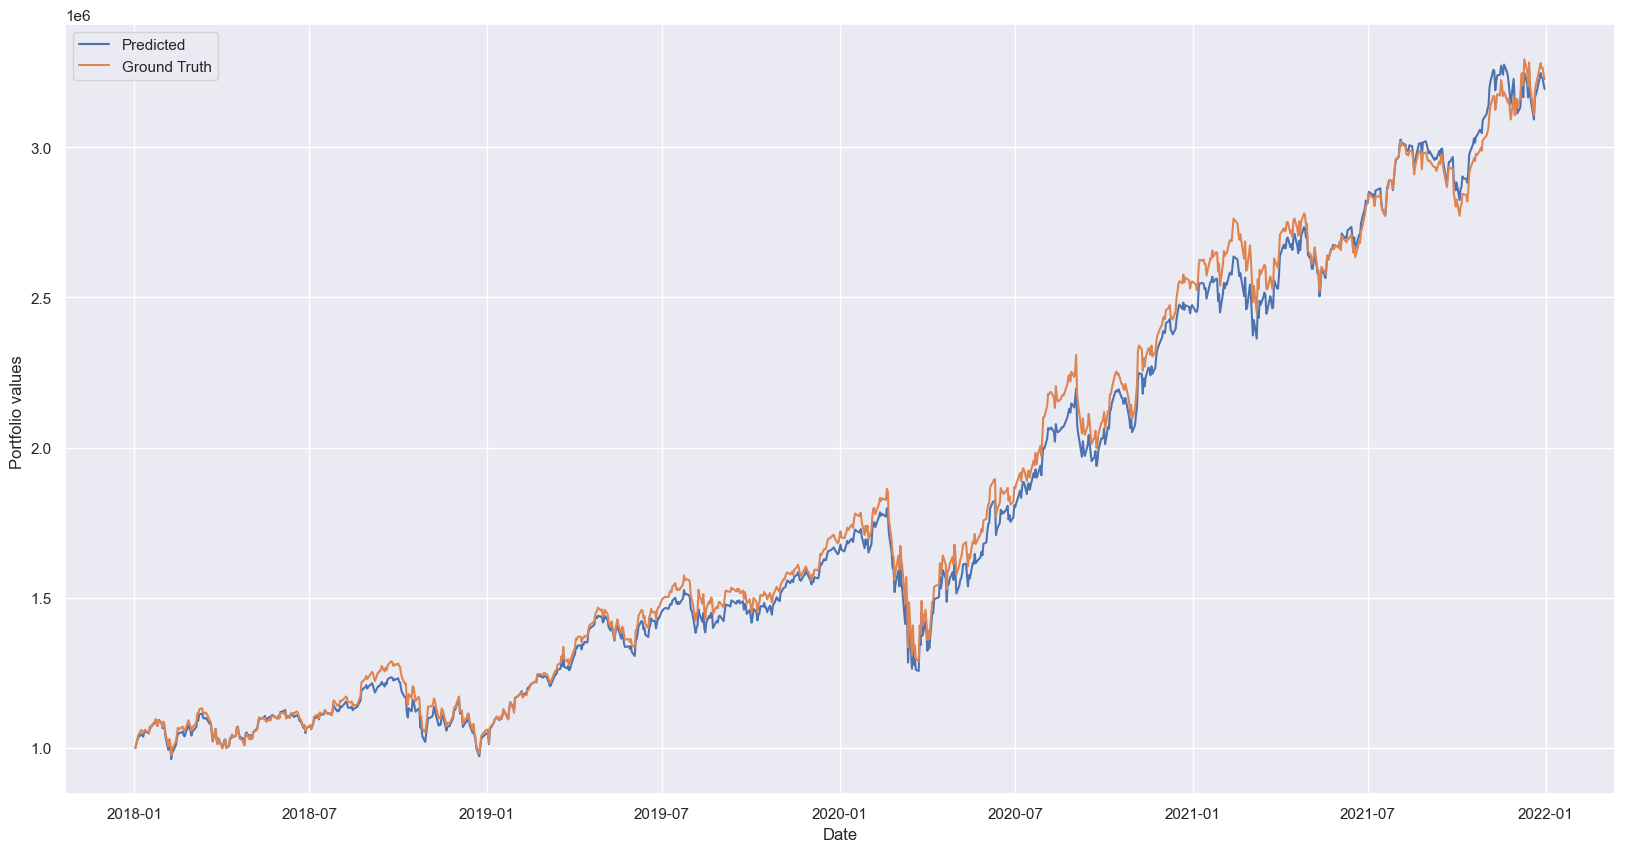

In [961]:
# historical portfolio values 
plt.plot(trade_y['date'].unique(), e_trade_gym.asset_memory[:-1], label='Predicted')
plt.plot(trade_y['date'].unique(), true_asset_memory_trade[:-1], label='Ground Truth')
plt.xlabel('Date')
plt.ylabel('Portfolio values ')
plt.legend()
plt.show()

Text(0, 0.5, 'Fitted ADSK')

Text(0, 0.5, 'Fitted AMD')

Text(0, 0.5, 'Fitted CSCO')

Text(0, 0.5, 'Fitted FSLR')

Text(0, 0.5, 'Fitted INTU')

Text(0, 0.5, 'Fitted LRCX')

Text(0, 0.5, 'Fitted MSFT')

Text(0, 0.5, 'Fitted ORCL')

Text(0, 0.5, 'Fitted QCOM')

Text(0, 0.5, 'Fitted TXN')

Text(0, 0.5, 'Fitted WU')

Text(0.5, 0, 'Date')

Text(0.5, 0.98, 'Weight Changes Over Time')

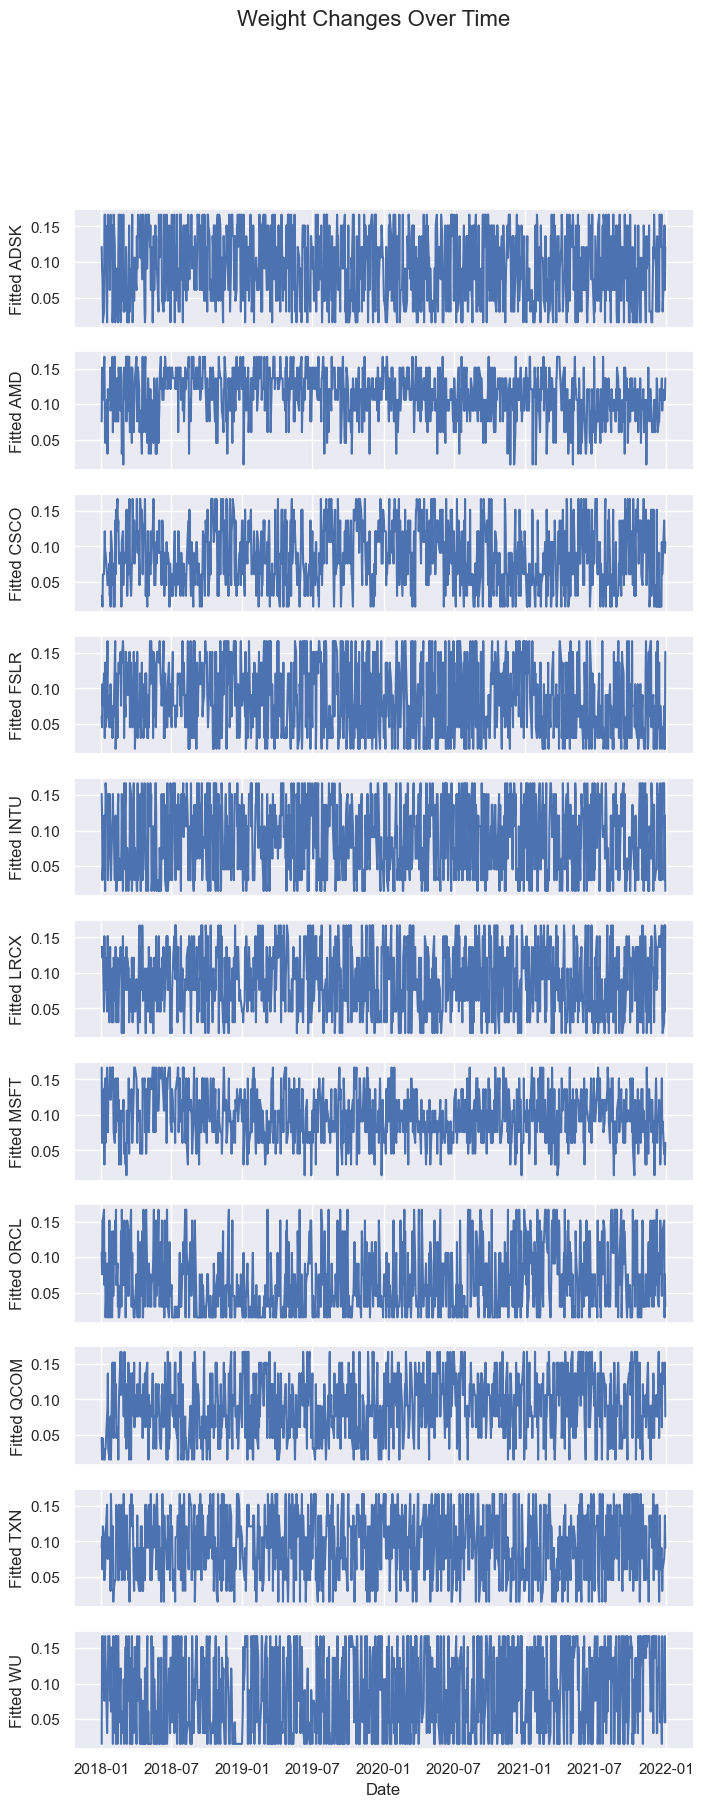

In [886]:
# how weights change over time (simulated vs. real)
# Hard to observe though!

selected_tech_tic = ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]
selected_tech_tic.sort()

true_action_memory_trade = np.asarray(true_action_memory_trade)

fig, axs = plt.subplots(nrows=11, ncols=1, figsize=(8, 20), sharex=True)

# Plot each weight column against the date column
for i in range(11):
    axs[i].plot(trade_y['date'].unique()[:-1], true_action_memory_trade[:, i])
    axs[i].set_ylabel("Fitted " + selected_tech_tic[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Date')
plt.suptitle('Weight Changes Over Time', fontsize=16)
plt.show()

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Cosine Similarity')

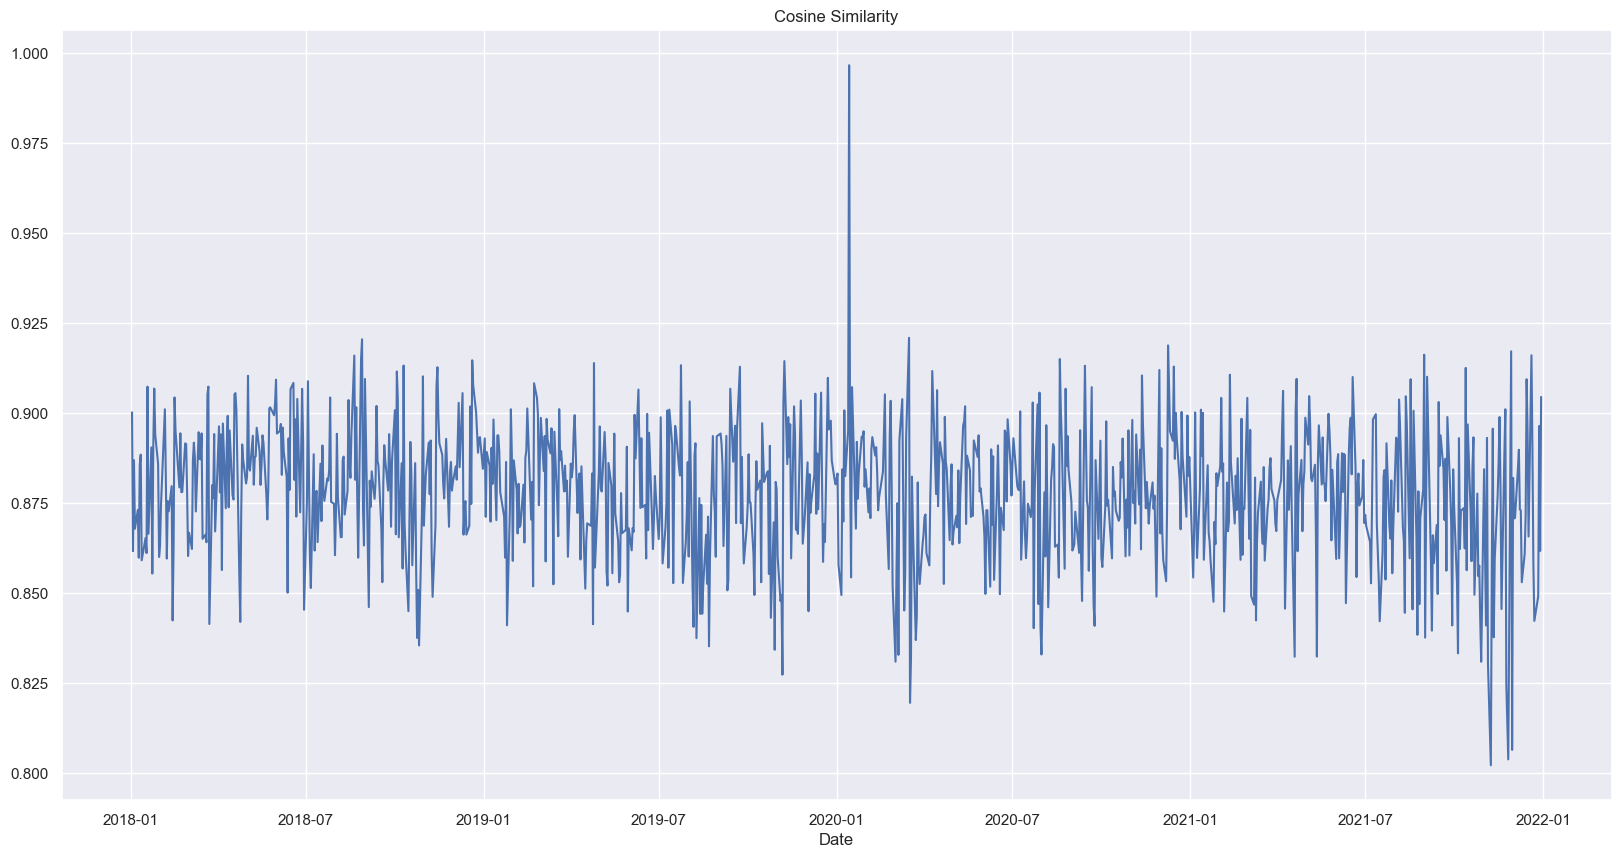

In [917]:
# Measures (OLS, cosine similarity, or correlation) of asset allocations

# Compute cosine similarity
from scipy.spatial.distance import cosine

cos_sims = [1 - cosine(true_action_memory_trade[i], e_trade_gym.actions_memory[i]) for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], cos_sims)
plt.xlabel('Date')
plt.title('Cosine Similarity')
plt.show()


In [973]:
# plt.plot(np.std(true_action_memory_trade, axis=1))
np.std(true_action_memory_trade, axis=1)

array([0.0479133, 0.0479133, 0.0479133, ..., 0.0479133, 0.0479133,
       0.0479133])

In [974]:
# plt.plot(np.std(e_trade_gym.actions_memory, axis=1))
np.std(e_trade_gym.actions_memory, axis=1)

array([0.0127882 , 0.01109528, 0.00998305, ..., 0.00969189, 0.00982149,
       0.00991314], dtype=float32)

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Correlation')

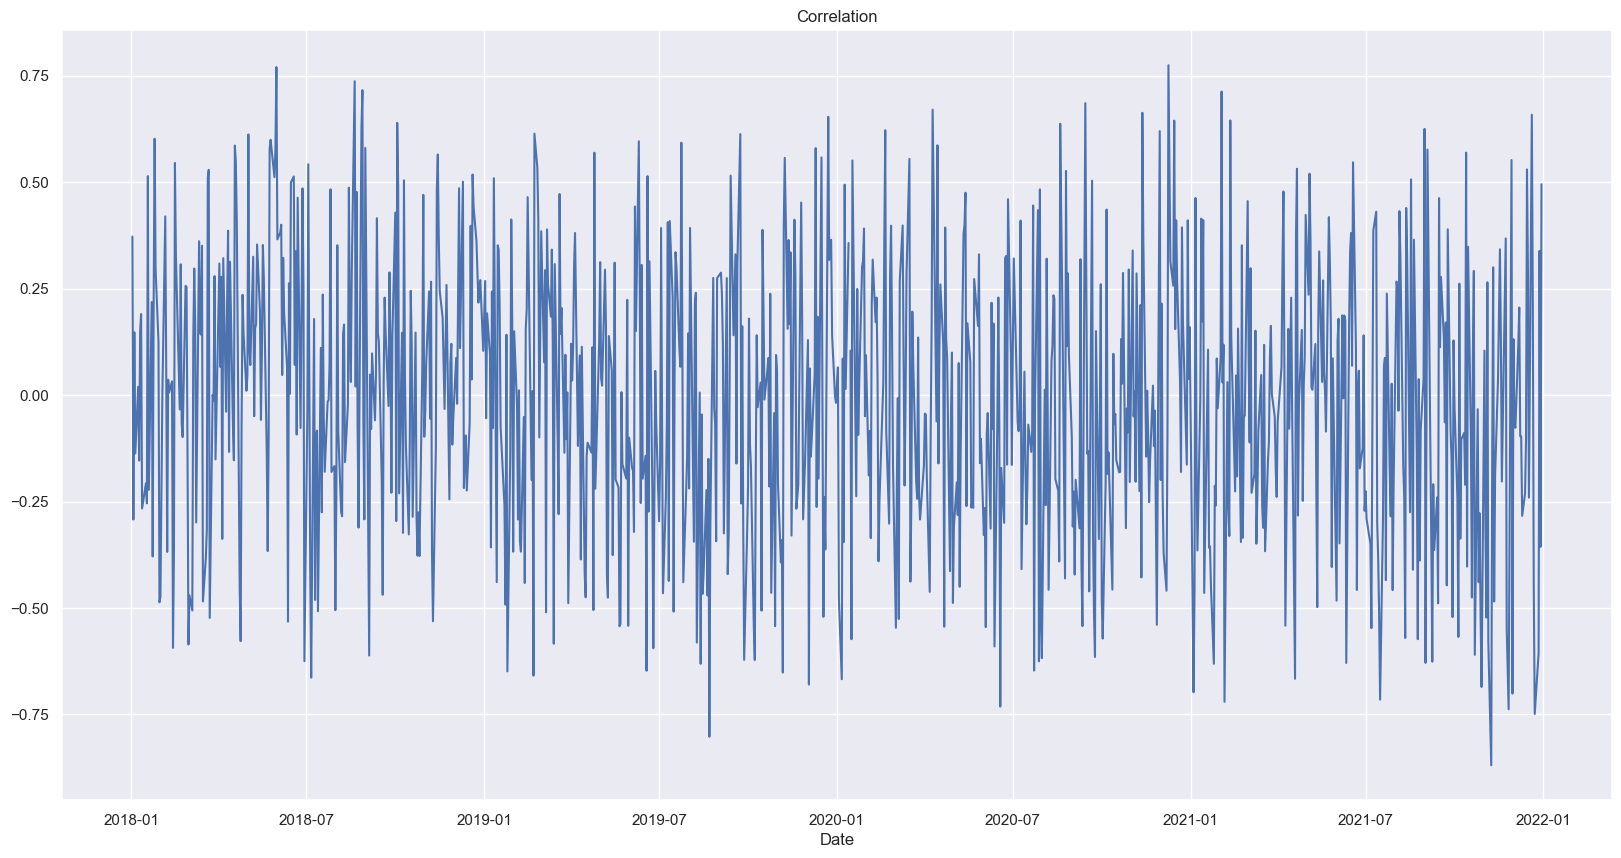

In [925]:
# correlation
corrcoef = [np.corrcoef(true_action_memory_trade[i], e_trade_gym.actions_memory[i])[0, 1]
                        for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], corrcoef)
plt.xlabel('Date')
plt.title('Correlation')
plt.show()

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'MSE')

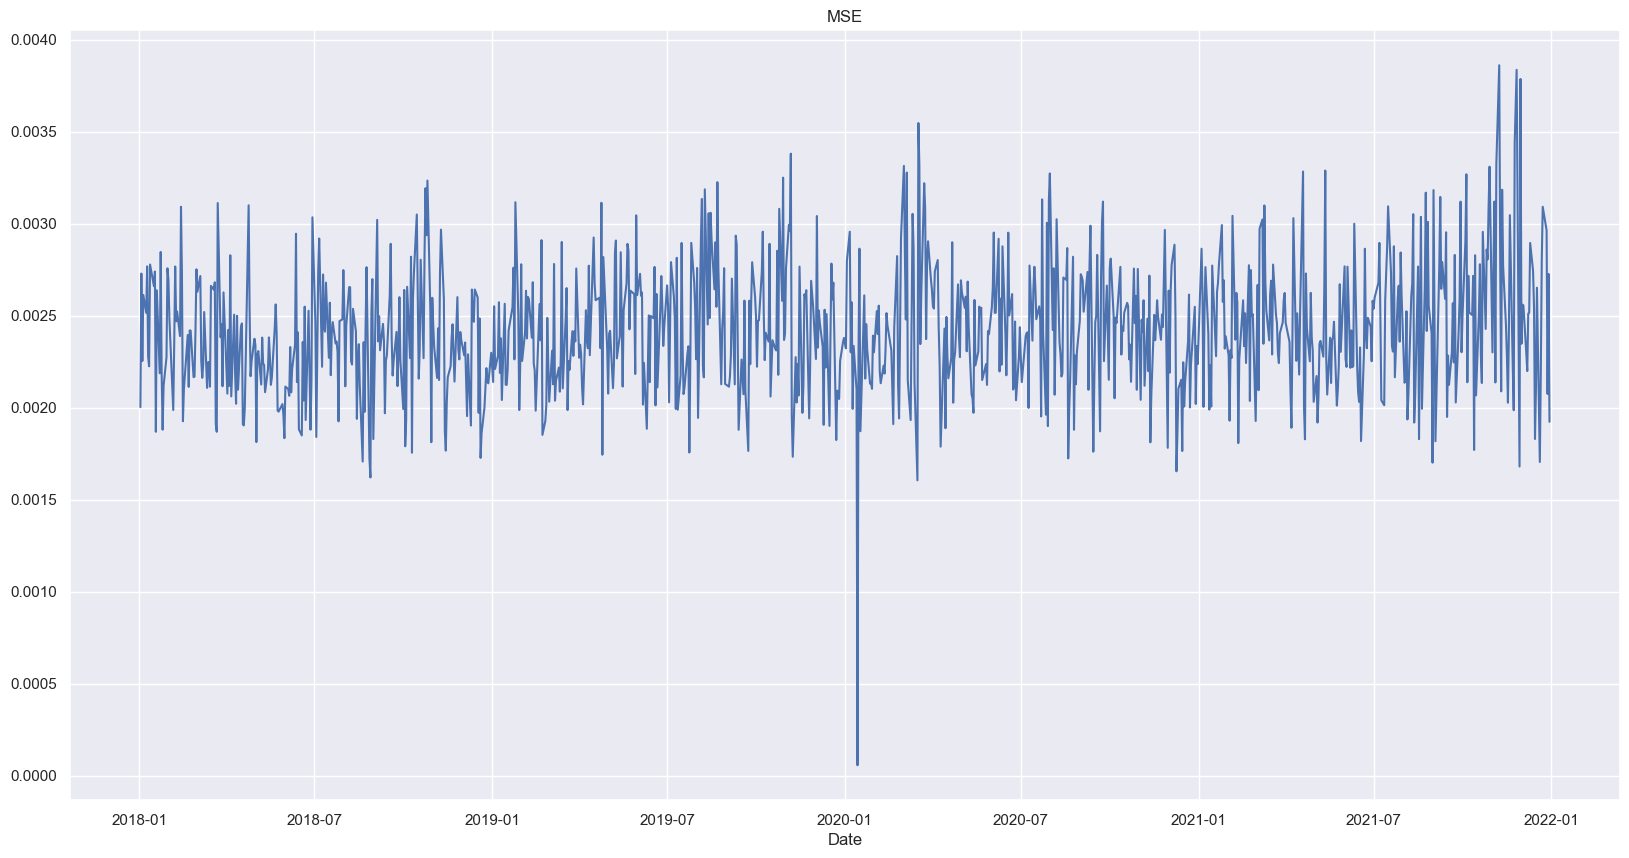

In [931]:
# MSE
from sklearn.metrics import mean_squared_error

mse = [mean_squared_error(true_action_memory_trade[i], e_trade_gym.actions_memory[i])
       for i in range(len(true_action_memory_trade))]
plt.plot(trade_y['date'].unique()[:-1], mse)
plt.xlabel('Date')
plt.title('MSE')
plt.show()

In [985]:
#fit linear regression model

# olsres = sm.OLS(np.asarray(true_action_memory_trade).reshape(-1), 
#                 np.asarray(e_trade_gym.actions_memory).reshape(-1)).fit()

# print(olsres.summary())

olsres = sm.OLS(pd.Series(true_asset_memory_trade[:-1]).pct_change(), 
                sm.add_constant(pd.Series(e_trade_gym.asset_memory[:-1]).pct_change()), missing="drop").fit()

# plt.plot(trade_y['date'].unique(), e_trade_gym.asset_memory[:-1], label='Predicted')
# plt.plot(trade_y['date'].unique(), true_asset_memory_trade[:-1], label='Ground Truth')

#view model summary
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 4.482e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:37:55   Log-Likelihood:                 4547.7
No. Observations:                1007   AIC:                            -9091.
Df Residuals:                    1005   BIC:                            -9082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.038e-05   8.37e-05     -0.124      0.9

In [ ]:
# Placebo tests: features (subset or random variables that has the mean and std) 
# imitate mean-var
# XLF

## Exploration to finetune (TD3+BC)

In [402]:
# Experiment
policy = "TD3+BC" # Policy name
env = e_train_gym # OpenAI gym environment name
seed = 0 # Sets Gym, PyTorch and Numpy seeds
eval_freq = 1e3 # How often (time steps) we evaluate
max_timesteps = 1e5 # Max time steps to run environment
save_model = True # Save model and optimizer parameters
load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
file_name = f"TD3_{seed}"

# TD3
expl_noise = 0.1 # Std of Gaussian exploration noise
batch_size = 256 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 0.2 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 2 # Frequency of delayed policy updates

# TD3 + BC
alpha = 0
beta = 1
normalize = True

In [403]:
# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

[0]

In [404]:
print("---------------------------------------")
print(f"Policy: {policy}, Env: {env}, Seed: {seed}")
print("---------------------------------------")

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": discount,
    "tau": tau,
    # TD3
    "policy_noise": policy_noise * max_action,
    "noise_clip": noise_clip * max_action,
    "policy_freq": policy_freq,
    # TD3 + BC
    "alpha": alpha,
    "beta": beta
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)
# policy.load(f"./models/BC_0")

---------------------------------------
Policy: TD3+BC, Env: <StockPortfolioEnv instance>, Seed: 0
---------------------------------------


In [405]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(train_dataset)

# flatten
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

if normalize:
    mean,std = replay_buffer.normalize_states() 
else:
    mean,std = 0,1

In [407]:
evaluations = []
portfolio_values = []
for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        print(f"Time steps: {t+1}")
        evaluations.append(eval_policy(policy, env, seed, mean, std))
        portfolio_values.append(env.portfolio_value)


Time steps: 1000
begin_total_asset:1000000
end_total_asset:3625406.6931786337
Sharpe:  0.5786711652452807
---------------------------------------
Evaluation over 1 episodes: 2600244.900
---------------------------------------
Time steps: 2000
begin_total_asset:1000000
end_total_asset:3585028.5287858606
Sharpe:  0.572955322430469
---------------------------------------
Evaluation over 1 episodes: 2558882.628
---------------------------------------
Time steps: 3000
begin_total_asset:1000000
end_total_asset:3832452.41238024
Sharpe:  0.5943158827444123
---------------------------------------
Evaluation over 1 episodes: 2804832.981
---------------------------------------
Time steps: 4000
begin_total_asset:1000000
end_total_asset:3848700.4518871247
Sharpe:  0.5951870630354568
---------------------------------------
Evaluation over 1 episodes: 2821896.209
---------------------------------------
Time steps: 5000
begin_total_asset:1000000
end_total_asset:3883714.014642218
Sharpe:  0.59864938756

Time steps: 29000
begin_total_asset:1000000
end_total_asset:4530627.377605429
Sharpe:  0.6470958506701773
---------------------------------------
Evaluation over 1 episodes: 3500354.564
---------------------------------------
Time steps: 30000
begin_total_asset:1000000
end_total_asset:4718419.386639884
Sharpe:  0.6614510007003417
---------------------------------------
Evaluation over 1 episodes: 3687155.304
---------------------------------------
Time steps: 31000
begin_total_asset:1000000
end_total_asset:4584161.633422363
Sharpe:  0.651476164655255
---------------------------------------
Evaluation over 1 episodes: 3553035.311
---------------------------------------
Time steps: 32000
begin_total_asset:1000000
end_total_asset:4677156.044710144
Sharpe:  0.6586609076518308
---------------------------------------
Evaluation over 1 episodes: 3645213.892
---------------------------------------
Time steps: 33000
begin_total_asset:1000000
end_total_asset:4529683.626504447
Sharpe:  0.64647206

Time steps: 57000
begin_total_asset:1000000
end_total_asset:5116014.989293023
Sharpe:  0.6875988390376706
---------------------------------------
Evaluation over 1 episodes: 4082471.538
---------------------------------------
Time steps: 58000
begin_total_asset:1000000
end_total_asset:4726217.14002038
Sharpe:  0.6609584565003161
---------------------------------------
Evaluation over 1 episodes: 3694027.649
---------------------------------------
Time steps: 59000
begin_total_asset:1000000
end_total_asset:4787779.393461115
Sharpe:  0.6658441118315183
---------------------------------------
Evaluation over 1 episodes: 3755474.819
---------------------------------------
Time steps: 60000
begin_total_asset:1000000
end_total_asset:4809377.171156335
Sharpe:  0.6675445527097388
---------------------------------------
Evaluation over 1 episodes: 3777277.434
---------------------------------------
Time steps: 61000
begin_total_asset:1000000
end_total_asset:4931335.739049146
Sharpe:  0.67493265

Time steps: 85000
begin_total_asset:1000000
end_total_asset:4905545.825289308
Sharpe:  0.6729561963470235
---------------------------------------
Evaluation over 1 episodes: 3872598.043
---------------------------------------
Time steps: 86000
begin_total_asset:1000000
end_total_asset:4826308.259105197
Sharpe:  0.6685444929972105
---------------------------------------
Evaluation over 1 episodes: 3793823.841
---------------------------------------
Time steps: 87000
begin_total_asset:1000000
end_total_asset:4816159.949058975
Sharpe:  0.6666625471093619
---------------------------------------
Evaluation over 1 episodes: 3783478.448
---------------------------------------
Time steps: 88000
begin_total_asset:1000000
end_total_asset:4878710.0432941
Sharpe:  0.6717977546493981
---------------------------------------
Evaluation over 1 episodes: 3845996.884
---------------------------------------
Time steps: 89000
begin_total_asset:1000000
end_total_asset:4908442.011301486
Sharpe:  0.673833940